# Optimization Problem
This file contains the first tries to develop a first version of the optimization problem. Especially, different ways of the computation of the expected value with piecewise pyomo functions have been investigated

## Testing Quadratic Example

In [1]:
cdf_approximations = lambda x: -1/3 * x**3 + x * (3/4)**(2/3) + 1/2

In [2]:
def simpsons_rule_quadratic(lb, ub, n, offset):
    h = (ub - lb) / n
    x = [lb + i*h for i in range(n+1)]
    integrand = lambda x: x * (-(x + offset)**2 + (3/4)**(2/3)) # todo: for higher integral it needs to be x * pdf(x+z)
    y = [integrand(xi) for xi in x]

    approximated_integral = h/3 * (y[0] + y[-1] + 4*sum(y[1:-1:2]) + 2*sum(y[2:-1:2]))
    return approximated_integral

In [3]:
import pyomo.environ as pyo

limits = pyo.sqrt((3/4)**(2/3))

model = pyo.ConcreteModel()

model.x_low = pyo.Var(domain=pyo.NonPositiveReals, bounds=(-limits, 0))
model.x_high = pyo.Var(domain=pyo.NonNegativeReals, bounds=(0, limits))

model.p_low = pyo.Var(bounds=(0, 1))
model.p_high = pyo.Var(bounds=(0, 1))

model.exp_low = pyo.Var()
model.exp_high = pyo.Var()

model.pg_low = pyo.Var()
model.pg_high = pyo.Var()


def constr_p_low(model):
    return model.p_low == cdf_approximations(model.x_low)
model.constr_p_low = pyo.Constraint(rule=constr_p_low)

def constr_p_high(model):
    return model.p_high == 1 - cdf_approximations(model.x_high)
model.constr_p_high = pyo.Constraint(rule=constr_p_high)


model.constr_x_low = pyo.Constraint(expr=model.x_low == -0.6)
model.constr_x_high = pyo.Constraint(expr=model.x_high == 0.2)


def constr_exp_low(model):
    return model.exp_low == simpsons_rule_quadratic(model.x_low, 0, 100, offset=0) 
model.constr_exp_low = pyo.Constraint(rule=constr_exp_low)

def constr_exp_high(model):
    return model.exp_high == simpsons_rule_quadratic(0, model.x_high, 100, offset=0)
model.constr_exp_high = pyo.Constraint(rule=constr_exp_high)


def constr_pg_low(model):
    return model.pg_low == simpsons_rule_quadratic(-limits - model.x_low, 0, 100, offset=model.x_low)
model.constr_pg_low = pyo.Constraint(rule=constr_pg_low)

def constr_pg_high(model):
    return model.pg_high == simpsons_rule_quadratic(0, limits - model.x_high, 100, offset=model.x_high)
model.constr_pg_high = pyo.Constraint(rule=constr_pg_high)



def objective_rule(model):
    return model.p_low + model.p_high
model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)


solver = pyo.SolverFactory('ipopt')
solver.options['max_iter'] = 2000
result = solver.solve(model, tee=True)

Ipopt 3.11.1: max_iter=2000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:       14
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        8
                     variables with only lower bounds:        0
                variables with lower and upper bou

In [4]:
model.display() 

Model unknown

  Variables:
    x_low : Size=1, Index=None
        Key  : Lower               : Value : Upper : Fixed : Stale : Domain
        None : -0.9085602964160698 :  -0.6 :     0 : False : False : NonPositiveReals
    x_high : Size=1, Index=None
        Key  : Lower : Value : Upper              : Fixed : Stale : Domain
        None :     0 :   0.2 : 0.9085602964160698 : False : False : NonNegativeReals
    p_low : Size=1, Index=None
        Key  : Lower : Value               : Upper : Fixed : Stale : Domain
        None :     0 : 0.07671091266580604 :     1 : False : False :  Reals
    p_high : Size=1, Index=None
        Key  : Lower : Value               : Upper : Fixed : Stale : Domain
        None :     0 : 0.33757030422193535 :     1 : False : False :  Reals
    exp_low : Size=1, Index=None
        Key  : Lower : Value                : Upper : Fixed : Stale : Domain
        None :  None : -0.11618672620025822 :  None : False : False :  Reals
    exp_high : Size=1, Index=None

## Testing Uniform example

In [5]:
cdf_approximations = lambda x, lb, ub: (x - lb) / (ub - lb)
#pdfs = lambda x, lb, ub: 1 / (ub - lb) 
#exp_value_function = lambda x, lb, ub: x * pdfs(x, lb, ub)

In [6]:
import numpy as np

def simpsons_rule_uniform(lb, ub, n, lb_pdf, ub_pdf):
    step = (ub - lb) / n
    x = [lb + i*step for i in range(n+1)]
    integrand = lambda x: x * 1 / (ub_pdf - lb_pdf)
    y = [integrand(x_i) for x_i in x]

    res = y[0] + y[-1] + 4 * sum(y[1:-1:2]) + 2 * sum(y[2:-1:2])
    return step / 3 * res

In [7]:
import pyomo.environ as pyo

limits = 5

model = pyo.ConcreteModel()

model.x_low = pyo.Var(domain=pyo.NonPositiveReals, bounds=(-limits, 0))
model.x_high = pyo.Var(domain=pyo.NonNegativeReals, bounds=(0, limits))

model.p_low = pyo.Var(bounds=(0, 1))
model.p_high = pyo.Var(bounds=(0, 1))

model.exp_low = pyo.Var()
model.exp_high = pyo.Var()

model.pg_low = pyo.Var()
model.pg_high = pyo.Var()


def constr_p_low(model):
    return model.p_low == cdf_approximations(model.x_low, -limits, limits)
model.constr_p_low = pyo.Constraint(rule=constr_p_low)

def constr_p_high(model):
    return model.p_high == 1 - cdf_approximations(model.x_high, -limits, limits)
model.constr_p_high = pyo.Constraint(rule=constr_p_high)


model.constr_x_low = pyo.Constraint(expr=model.x_low == -3)
model.constr_x_high = pyo.Constraint(expr=model.x_high == 1)


def constr_exp_low(model):
    return model.exp_low == simpsons_rule_uniform(model.x_low, 0, 100, -limits, limits) 
model.constr_exp_low = pyo.Constraint(rule=constr_exp_low)

def constr_exp_high(model):
    return model.exp_high == simpsons_rule_uniform(0, model.x_high, 100, -limits, limits)
model.constr_exp_high = pyo.Constraint(rule=constr_exp_high)


def constr_pg_low(model):
    return model.pg_low == simpsons_rule_uniform(-limits - model.x_low, 0, 100, -limits, limits)
model.constr_pg_low = pyo.Constraint(rule=constr_pg_low)

def constr_pg_high(model):
    return model.pg_high == simpsons_rule_uniform(0, limits - model.x_high, 100, -limits, limits)
model.constr_pg_high = pyo.Constraint(rule=constr_pg_high)



def objective_rule(model):
    return model.p_low + model.p_high
model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)


solver = pyo.SolverFactory('ipopt')
solver.options['max_iter'] = 2000
result = solver.solve(model, tee=True)

Ipopt 3.11.1: max_iter=2000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:       14
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        8
                     variables with only lower bounds:        0
                variables with lower and upper bou

In [8]:
model.display()

Model unknown

  Variables:
    x_low : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :    -5 :  -3.0 :     0 : False : False : NonPositiveReals
    x_high : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :   1.0 :     5 : False : False : NonNegativeReals
    p_low : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :   0.2 :     1 : False : False :  Reals
    p_high : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :   0.4 :     1 : False : False :  Reals
    exp_low : Size=1, Index=None
        Key  : Lower : Value                : Upper : Fixed : Stale : Domain
        None :  None : -0.44999999999999984 :  None : False : False :  Reals
    exp_high : Size=1, Index=None
        Key  : Lower : Value               : Upper : Fixed : Stale : Domain
        None :  None : 0.05000000

In [9]:
import numpy as np

def simpsons_rule_uniform(lb, ub, n, lb_pdf, ub_pdf):
    step = (ub - lb) / n
    x = np.linspace(lb, ub, n+1)
    integrand = lambda x: x * 1 / (ub_pdf - lb_pdf)
    y = [integrand(x_i) for x_i in x]

    res = y[0] + y[-1] + 4 * sum(y[1:-1:2]) + 2 * sum(y[2:-1:2])
    return step / 3 * res

exp_test = simpsons_rule_uniform(-3, 0, 100, lb_pdf=-5, ub_pdf=5)
print(f"Result of Simpson's rule: {exp_test:.6f}")


Result of Simpson's rule: -0.450000


In [10]:
test_func1 = lambda x, lb, ub: x * 1 / (ub - lb)
def simpsons_rule_uniform(lb, ub, n, integrand, lb_pdf, ub_pdf):
    step = (ub - lb) / n
    x = [lb + i*step for i in range(n+1)]
    y = [integrand(x_i, lb_pdf, ub_pdf) for x_i in x]

    res = y[0] + y[-1] + 4*sum(y[1:-1:2]) + 2*sum(y[2:-1:2])
    return step/3 * res

exp_test = simpsons_rule_uniform(-3, 0, 100, test_func1, lb_pdf=-5, ub_pdf=5) # This should be -0.45 instead of -1.5


In [11]:
exp_test

-0.45000000000000007

In [12]:
from scipy import integrate
a = integrate.quad(lambda x: x * 1 / 10, -3, 0)
b = integrate.quad(lambda x: x * 1 / 10, 0, 1)
c = integrate.quad(lambda x: x * 1 / 10, -3, 1)
a

(-0.44999999999999996, 4.996003610813204e-15)

In [13]:
b

(0.049999999999999996, 5.551115123125783e-16)

In [14]:
c

(-0.4, 5.5573353616138396e-15)

## Testing cdf approximation for pyomo
Im trying to express a gaussian cdf via pyomo-internal math functions

In [15]:
from math import pi
from scipy.stats import norm
cdf_scipy = lambda x, mu, sig: norm.cdf(x, mu, sig)
cdf_long = lambda x, mu, sig: 0.5 + 1/(2*pi)**0.5 * ((x - mu)/sig - ((x-mu)/sig)**3 / 6 + ((x-mu)/sig)**5 / 40 -((x-mu)/sig)**7 / 336 + ((x-mu)/sig)**9 / 3456 - ((x-mu)/sig)**11 / 42240 + ((x-mu)/sig)**13 / 599040 - ((x-mu)/sig)**15 / 9676800 + ((x-mu)/sig)**17 / 174182400 - ((x-mu)/sig)**19 / 3483648000 + ((x-mu)/sig)**21 / 77594608800 - ((x-mu)/sig)**23 / 1939865221120 + ((x-mu)/sig)**25 / 53313423411200 - ((x-mu)/sig)**27 / 1599402702336000 + ((x-mu)/sig)**29 / 51891840013440000 - ((x-mu)/sig)**31 / 1819454240519680000 + ((x-mu)/sig)**33 / 68102894857651200000 - ((x-mu)/sig)**35 / 2724115794306048000000 + ((x-mu)/sig)**37 / 115542582099609600000000 - ((x-mu)/sig)**39 / 5189411429617420800000000 + ((x-mu)/sig)**41 / 247047418309826560000000000 - ((x-mu)/sig)**43 / 12352370915491328000000000000 + ((x-mu)/sig)**45 / 646502291289292800000000000000 - ((x-mu)/sig)**47 / 35557669959969817600000000000000 + ((x-mu)/sig)**49 / 2057706092778373120000000000000000 - ((x-mu)/sig)**51 / 125520570919964019200000000000000000 + ((x-mu)/sig)**53 / 7976644307687257088000000000000000000 - ((x-mu)/sig)**55 / 531776287179150472960000000000000000000 + ((x-mu)/sig)**57 / 37024340102340533043200000000000000000000 - ((x-mu)/sig)**59 / 2702125959664681495040000000000000000000000 )
cdf_sum_approx = lambda x, mu, sig: 0.5 + 1/(2*pi)**0.5 * ((x - mu)/sig - ((x-mu)/sig)**3 / 6 + ((x-mu)/sig)**5 / 40 -((x-mu)/sig)**7 / 336 + ((x-mu)/sig)**9 / (16*24*9) - ((x-mu)/sig)**11 / (32*120*11) + ((x-mu)/sig)**13 / (64*720*13) - ((x-mu)/sig)**15 / 9676800 + ((x-mu)/sig)**17 / 174182400)

# No Taylor series needed for this cdf approximation. Double Facotrial !! is used here (For formula see https://en.wikipedia.org/wiki/Normal_distribution) Sorry for everyone
cdf = lambda x, mu, sig, n: 0.5 + 1/(2*pi)**0.5 * pyo.exp(-0.5 * ((x-mu)/sig)**2) * sum([((x-mu)/sig)**(i) / (pyo.prod(range(1, i+1, 2))) for i in range(1, 2*n, 2)])

In [16]:
cdf_scipy(-2.625, -2, 0.5)

0.10564977366685535

In [17]:
cdf(-2.625, -2, 0.5, 30)

0.10564977366685524

In [18]:
# Minimal pyomo example
import pyomo.environ as pyo

mu = 0
sig = 1
limit = 3*sig # 3 standard deviations equals 99.7% of the data => Taylor approximation => The further away from mu, the worse it is. p1 and p2 should be limited to be in bounds 0,1!
n = 30

model = pyo.ConcreteModel()
model.x = pyo.Var(domain=pyo.Reals, bounds=(-limit, limit))
model.p1 = pyo.Var(domain=pyo.Reals, bounds=(0, 1))
model.p2 = pyo.Var(domain=pyo.Reals, bounds=(0, 1))

def p_constr(model):
    #return model.p1 == cdf_scipy(model.x, mu, sig)
    return model.p1 == cdf(model.x, mu, sig, n)
model.p_constr = pyo.Constraint(rule=p_constr)

def p_constr2(model):
    return model.p2 == 1 - cdf(model.x, mu, sig, n)
model.p_constr2 = pyo.Constraint(rule=p_constr2)

def obj_rule(model):
    return model.x -model.p1 - model.p2
model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

solver = pyo.SolverFactory('ipopt')
solver.solve(model)

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2, 'Number of variables': 3, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.040354251861572266}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

In [19]:
model.obj.display()

obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True :  -4.0


In [20]:
cdf_scipy(model.x(), mu, sig)

0.001349898031630093

In [21]:
model.x.display()

x : Size=1, Index=None
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None :    -3 :  -3.0 :     3 : False : False :  Reals


In [22]:
model.p1.display()

p1 : Size=1, Index=None
    Key  : Lower : Value                 : Upper : Fixed : Stale : Domain
    None :     0 : 0.0013498979096696552 :     1 : False : False :  Reals


## Testing integral approximation for Pyomo
In order to compute expected values, integrals need to be computed/approximated

In [23]:
from scipy import integrate
test = lambda x: x**2
integrate.quad(test, 0, 4)

(21.333333333333336, 2.368475785867001e-13)

In [24]:
pdf_approximations = lambda x, mu, sig: 1/((2*pi)**0.5 * sig) * pyo.exp(-0.5 * ((x-mu)/sig)**2) # Normal distribution

In [25]:
# pyomo example with integral
import pyomo.environ as pyo
from math import pi

def pdf_normal(x, mu=0, sig=1):
    return 1/((2*pi)**0.5 * sig) * pyo.exp(-0.5 * ((x - mu)/sig)**2)

expected_val = lambda x: x*pdf_normal(x)

# rectangular approximation
#integrand = lambda lb, ub, func: (ub - lb) * (func((ub+lb)/2))

# trapezoidal approximation
#integrand = lambda lb, ub, func: (ub - lb) * (func(lb) + func(ub)) / 2
integrand = lambda lb, ub, n, func: (ub - lb)/n * (func(lb)/2 + sum([func(lb + (k+1)*(ub-lb)/n) for k in range(n-1)]) + func(ub)/2)

# Simpson's approximation
#integrand = lambda lb, ub, func: 1/3 * (ub - lb)/2 * (func(lb) + 4 * func((lb + ub) / 2) + func(ub))
def simpsons_rule(lb, ub, n, integrand):
    step = (ub - lb) / n
    x = [lb + i*step for i in range(n+1)]
    y = [integrand(x_i) for x_i in x]

    res = y[0] + y[-1] + 4*sum(y[1:-1:2]) + 2*sum(y[2:-1:2])
    return step/3 * res

# todo: implement gaussian quadrature and/or Clenshaw-Curtis quadrature for better accuracy (due to unevenly spaced points)
# for now, we will use Simpson's rule


model = pyo.ConcreteModel()

model.x = pyo.Var(domain=pyo.Reals, bounds=(0, 3))
model.exp_val = pyo.Var(domain=pyo.Reals)

def exp_val_constr(model):
    #return model.exp_val == integrand(0, model.x, pdf)
    #return model.exp_val == integrand(0, model.x, 100, pdf_normal)
    return model.exp_val == simpsons_rule(0, model.x, 100, expected_val)
model.exp_val_constr = pyo.Constraint(rule=exp_val_constr)

def obj_rule(model):
    return model.exp_val
model.obj = pyo.Objective(rule=obj_rule, sense=pyo.maximize)

solver = pyo.SolverFactory('ipopt')
solver.solve(model)

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 1, 'Number of variables': 2, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.03935098648071289}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

In [26]:
def simpsons_rule_sig(lb, ub, n, integrand, sig):
    step = (ub - lb) / n
    x = [lb + i*step for i in range(n+1)]
    y = [integrand(x_i, sig) for x_i in x]

    res = y[0] + y[-1] + 4*sum(y[1:-1:2]) + 2*sum(y[2:-1:2])
    return step/3 * res
expected_val = lambda x, sig: x*pdf_normal(x, sig=sig)
simpsons_rule_sig(0, 2, 100, expected_val, sig=1)

0.3449513151922788

In [27]:
a = simpsons_rule_sig(0, 1, 100, expected_val, sig=1)
b = simpsons_rule_sig(1, 2, 100, expected_val, sig=1)
a+b

0.3449513139697361

In [28]:
pdfs = lambda x, mu, sig: 1/((2*pi)**0.5 * sig) * pyo.exp(-0.5 * ((x-mu)/sig)**2) 
exp_value_function = lambda x, sig: x * pdfs(x, mu=0, sig=sig)
exp_value_offset = lambda x, sig, offset: x * pdfs(x+offset, mu=0, sig=sig)

In [29]:
x1 = -5
simpsons_rule_sig(-10, 0, 100, exp_value_function, sig)

-0.3989429492923542

In [30]:
def simpsons_rule_sig_offset(lb, ub, n, integrand, sig, offset):
    step = (ub - lb) / n
    x = [lb + i*step for i in range(n+1)]
    y = [integrand(x_i, sig, offset) for x_i in x]

    res = y[0] + y[-1] + 4*sum(y[1:-1:2]) + 2*sum(y[2:-1:2])
    return step/3 * res
simpsons_rule_sig_offset(-10, 0, 100, exp_value_offset, sig, x1)

-5.340448410609342e-08

In [31]:
# This seems to work
exp_battery_max = simpsons_rule_sig(-6, 0, 1000, exp_value_function, sig=1)  # x_low = -6
exp_grid_max = simpsons_rule_sig_offset(-10, 0, 1000, exp_value_offset, sig=1, offset=0)  # x_low = 0

print("Exp-battery-max: ", exp_battery_max, " Exp-grid-max: ", exp_grid_max)


Exp-battery-max:  -0.3989422743341672  Exp-grid-max:  -0.39894228046792707


In [32]:
# Sum doesnt add up but this might be okay as long as pb_tilde = -pg_tilde
x_low = -0.5
exp_bat1 = simpsons_rule_sig(x_low, 0, 1000, exp_value_function, sig=1)  # x_low = -6
exp_grid1 = simpsons_rule_sig_offset(-10, 0, 1000, exp_value_offset, sig=1, offset=x_low)  # x_low = 0

print("Exp-battery-max: ", exp_bat1, " Exp-grid-max: ", exp_grid1, " Total: ", exp_bat1 + exp_grid1)

Exp-battery-max:  -0.046876953637133435  Exp-grid-max:  -0.19779655744531602  Total:  -0.24467351108244945


In [33]:
model.obj.display()

obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 0.3945104342542512


In [34]:
model.x.display()

x : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :     0 : 2.9999997844863255 :     3 : False : False :  Reals


In [35]:
cdf_scipy = lambda x, mu, sig: norm.cdf(x, mu, sig)
area = - cdf_scipy(0, 0, 1) + cdf_scipy(3, 0, 1)
area


0.4986501019683699

In [36]:
pdf_normal(3, 0, 1)

0.0044318484119380075

## Other Stuff

In [37]:
import pandas as pd
path = 'C:\\Users\\fh6281\\PycharmProjects\\UncertaintySplitting\\data\\forecasts\\example-forecasts\\expected_value_forecast.csv'
fc_exp = pd.read_csv(path, index_col=0)
fc_exp.index = pd.to_datetime(fc_exp.index)
if fc_exp.index.freq is None:
    fc_exp.index.freq = pd.infer_freq(fc_exp.index)
#fc_exp = pd.read_csv(path, index_col=0)

In [49]:
fc_exp.iloc[:, 0].to_dict()

{Timestamp('2024-06-01 00:00:00'): 0.4779425627008231,
 Timestamp('2024-06-01 01:00:00'): 0.4346184374783187,
 Timestamp('2024-06-01 02:00:00'): 0.4335427868245828,
 Timestamp('2024-06-01 03:00:00'): 0.4345916088933521,
 Timestamp('2024-06-01 04:00:00'): 0.4478578959516239,
 Timestamp('2024-06-01 05:00:00'): 0.467224009057789,
 Timestamp('2024-06-01 06:00:00'): 0.9037651394665092,
 Timestamp('2024-06-01 07:00:00'): 0.4733544370204661,
 Timestamp('2024-06-01 08:00:00'): 0.1391594750682512,
 Timestamp('2024-06-01 09:00:00'): -0.1172073778911971,
 Timestamp('2024-06-01 10:00:00'): -0.2966160891301591,
 Timestamp('2024-06-01 11:00:00'): -0.358949458562816,
 Timestamp('2024-06-01 12:00:00'): -0.3139020577470461,
 Timestamp('2024-06-01 13:00:00'): -0.258992659144856,
 Timestamp('2024-06-01 14:00:00'): -0.1360766560067279,
 Timestamp('2024-06-01 15:00:00'): 0.111222200097253,
 Timestamp('2024-06-01 16:00:00'): 0.3693184988433211,
 Timestamp('2024-06-01 17:00:00'): 0.6949445586940557,
 Timesta

In [60]:
path_w = 'C:\\Users\\fh6281\\PycharmProjects\\UncertaintySplitting\\data\\forecasts\\example-forecasts\\cdf_weights.csv'
fc_w = pd.read_csv(path_w, index_col=0)
fc_w.index = pd.to_datetime(fc_w.index)
if fc_w.index.freq is None:
    fc_w.index.freq = pd.infer_freq(fc_w.index)


In [65]:
fc_w.columns

Index(['w1', 'w2', 'w3', 'w4', 'w5', 'w6'], dtype='object')

In [64]:
fc_w.to_dict()

{'w1': {Timestamp('2024-06-01 00:00:00'): 0.41303715,
  Timestamp('2024-06-01 01:00:00'): 0.84935972,
  Timestamp('2024-06-01 02:00:00'): 0.849794573,
  Timestamp('2024-06-01 03:00:00'): 0.81792602,
  Timestamp('2024-06-01 04:00:00'): 0.06821815,
  Timestamp('2024-06-01 05:00:00'): 0.77422887,
  Timestamp('2024-06-01 06:00:00'): 0.69244909,
  Timestamp('2024-06-01 07:00:00'): 0.14881809,
  Timestamp('2024-06-01 08:00:00'): 0.13322491,
  Timestamp('2024-06-01 09:00:00'): 0.56592544,
  Timestamp('2024-06-01 10:00:00'): 0.472933735,
  Timestamp('2024-06-01 11:00:00'): 0.45976048,
  Timestamp('2024-06-01 12:00:00'): 0.60179745,
  Timestamp('2024-06-01 13:00:00'): 0.9078006,
  Timestamp('2024-06-01 14:00:00'): 0.90021239,
  Timestamp('2024-06-01 15:00:00'): 0.28850564,
  Timestamp('2024-06-01 16:00:00'): 0.62358733,
  Timestamp('2024-06-01 17:00:00'): 411.84945652,
  Timestamp('2024-06-01 18:00:00'): 0.38286674,
  Timestamp('2024-06-01 19:00:00'): 0.936875911,
  Timestamp('2024-06-01 20:00:

In [39]:
index=pd.date_range(start=start_date, periods=24, freq='h')

NameError: name 'start_date' is not defined

In [ ]:
fc_exp.index

Index(['2024-06-01 00:00', '2024-06-01 01:00', '2024-06-01 02:00',
       '2024-06-01 03:00', '2024-06-01 04:00', '2024-06-01 05:00',
       '2024-06-01 06:00', '2024-06-01 07:00', '2024-06-01 08:00',
       '2024-06-01 09:00', '2024-06-01 10:00', '2024-06-01 11:00',
       '2024-06-01 12:00', '2024-06-01 13:00', '2024-06-01 14:00',
       '2024-06-01 15:00', '2024-06-01 16:00', '2024-06-01 17:00',
       '2024-06-01 18:00', '2024-06-01 19:00', '2024-06-01 20:00',
       '2024-06-01 21:00', '2024-06-01 22:00', '2024-06-01 23:00'],
      dtype='object', name='timestamp')

In [ ]:
fc_exp.index = pd.to_datetime(fc_exp.index)


In [ ]:
a = fc_exp.index.freq

In [ ]:
print(a)

None


In [ ]:
prosumption_forecast = pd.DataFrame({'prosumption': np.array([2]*3)}, index=pd.date_range(start='1/1/2020', periods=3, freq='h'))

model = pyo.ConcreteModel()

different_variances = np.array([0.5, 1, 2])

model.time = pyo.Set(initialize=prosumption_forecast.index)

model.param = pyo.Param(model.time, initialize={t: different_variances[i] for i, t in enumerate(model.time)})

model.x = pyo.Var(model.time, domain=pyo.Reals, bounds=(0, 3))


In [ ]:
import pandas as pd
import numpy as np
from scipy import integrate
import scipy.stats as stats
import pyomo.environ as pyo
import matplotlib.pyplot as plt

In [ ]:
different_variances = [0.5, 1, 2, 10]

cdf_norm = [lambda z, scale=scale: stats.norm.cdf(z, loc=0, scale=scale) for scale in different_variances]
pdf_norm = [lambda z, scale=scale: stats.norm.pdf(z, loc=0, scale=scale) for scale in different_variances]
cdf_uniform = [lambda z, scale=scale: stats.uniform.cdf(z, loc=-scale/2, scale=scale) for scale in different_variances]
pdf_uniform = [lambda z, scale=scale: stats.uniform.pdf(z, loc=-scale/2, scale=scale) for scale in different_variances]

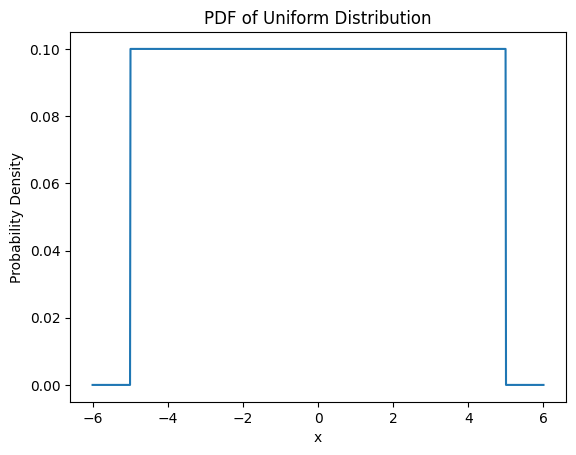

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

x = np.linspace(-6, 6, 1000)
y = pdf_uniform[3](x)

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('PDF of Uniform Distribution')
plt.show()

In [ ]:
x_low_range = np.linspace(-6.0, 0, 61)  # Define the range and resolution as needed
x_low_range

array([-6. , -5.9, -5.8, -5.7, -5.6, -5.5, -5.4, -5.3, -5.2, -5.1, -5. ,
       -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -4.1, -4. , -3.9,
       -3.8, -3.7, -3.6, -3.5, -3.4, -3.3, -3.2, -3.1, -3. , -2.9, -2.8,
       -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. , -1.9, -1.8, -1.7,
       -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6,
       -0.5, -0.4, -0.3, -0.2, -0.1,  0. ])

In [ ]:
def compute_expected_value(pdf_func, a, b): 
    integrand = lambda z: z * pdf_func(z)
    expected_val, _ = integrate.quad(integrand, a, b)
    return expected_val

In [ ]:
# Testing a minimal uniform example
import pyomo.environ as pyo
from scipy import stats
import numpy as np

# Define the uniform distribution CDF and PDF functions
limit = 5.0
scale = 10
cdf_func = lambda z: stats.uniform.cdf(z, loc=-scale/2, scale=scale)
pdf_func = lambda z: stats.uniform.pdf(z, loc=-scale/2, scale=scale)

# Generate breakpoints and function values for the piecewise constraints
x_range_low = np.linspace(-limit, 0, 10)
x_range_high = np.linspace(0, limit, 10)

cdf_values_low = [cdf_func(x) for x in x_range_low]
cdf_values_high = [1 - cdf_func(x) for x in x_range_high]


# test cdf with ups and downs !!!!!!!!!
cdf_values_low[-1] = cdf_values_low[-2] + 0.1

# With total range => prob2 is smaller than 0.5 which should not be possible
x_range_total = np.linspace(-limit, limit, 200)
cdf_values_total = [cdf_func(x) for x in x_range_total]

# Create a ConcreteModel
model = pyo.ConcreteModel()

# Define decision variables
model.x_low = pyo.Var(domain=pyo.Reals, bounds=(-limit, 0))
model.x_high = pyo.Var(domain=pyo.Reals, bounds=(0, limit))
model.prob1 = pyo.Var(domain=pyo.Reals, bounds=(0, 1))
model.prob2 = pyo.Var(domain=pyo.Reals, bounds=(0, 1))   

model.int_low = pyo.Var(domain=pyo.Reals)
model.int_high = pyo.Var(domain=pyo.Reals,)

def constr_x_low(model):
    return model.x_low == -3
model.constr_x_low = pyo.Constraint(rule=constr_x_low)

def constr_x_high(model):
    return model.x_high == 1.0
model.constr_x_high = pyo.Constraint(rule=constr_x_high)

# Define piecewise constraints for prob1 and prob2
model.pw_prob1 = pyo.Piecewise(
    model.prob1,                   # Variable to be constrained
    model.x_low,                   # x-coordinate for the piecewise function
    pw_pts=x_range_low.tolist(),       # Breakpoints for the piecewise function
    f_rule=cdf_values_low,             # Values of the piecewise function at the breakpoints
    pw_constr_type='EQ'            # Specifies that the constraints are equalities
)

model.pw_prob2 = pyo.Piecewise(
    model.prob2,
    model.x_high,
    pw_pts=x_range_high.tolist(),
    f_rule=cdf_values_high,
    pw_constr_type='EQ'
)

#test = [-0.45 for x in x_range_low]
test = [-0.95, *list(np.linspace(-0.95, -0.0, len(x_range_low)-2)), 0.0]
int_low_values = [compute_expected_value(pdf_func, x, 0) for x in x_range_low]
model.pw_int_low = pyo.Piecewise(
    model.int_low,
    model.x_low,
    pw_pts=x_range_low.tolist(),
    f_rule=int_low_values,#[-0.45 for x in x_range_low],#int_low_values,
    pw_constr_type='EQ'
)


int_high_values = [compute_expected_value(pdf_func, 0, x) for x in x_range_high]
model.pw_int_high = pyo.Piecewise(
    model.int_high,
    model.x_high,
    pw_pts=x_range_high.tolist(),
    f_rule=int_high_values,
    pw_constr_type='EQ'
)

# Define an example objective function
def objective_rule(model):
    return model.prob1 + model.prob2
model.obj = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# Solve the model
solver = pyo.SolverFactory('ipopt')
solver.solve(model, tee=True)

# Display the results
print(f"x_low = {model.x_low.value}, x_high = {model.x_high.value}, prob1 = {model.prob1.value}, prob2 = {model.prob2.value}, int_low = {model.int_low.value}, int_high = {model.int_high.value}")


**WARNING: Piecewise component 'pw_prob1[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'pw_prob2[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt document

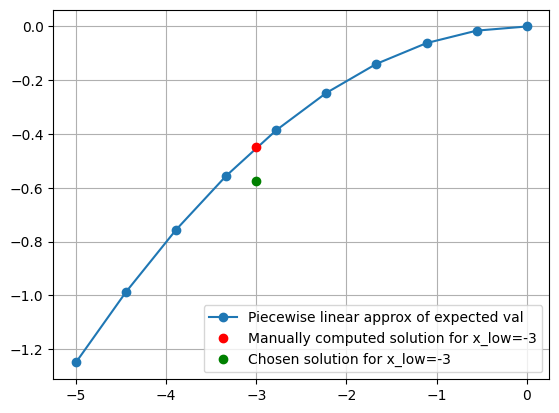

In [ ]:
plt.plot(x_range_low, int_low_values, '-o', label='Piecewise linear approx of expected val')
plt.plot([-3], [-0.45], 'ro', label='Manually computed solution for x_low=-3')
plt.plot([-3], [model.int_low.value], 'go', label='Chosen solution for x_low=-3')
plt.grid()
plt.legend()

In [ ]:
#plt.plot([x_range_low[0], x_range_low[4], x_range_low[5], x_range_low[-1]], [int_low_values[0], int_low_values[4], int_low_values[5], int_low_values[-1]], 'ro-', label='Manually computed solution for x_high=1')

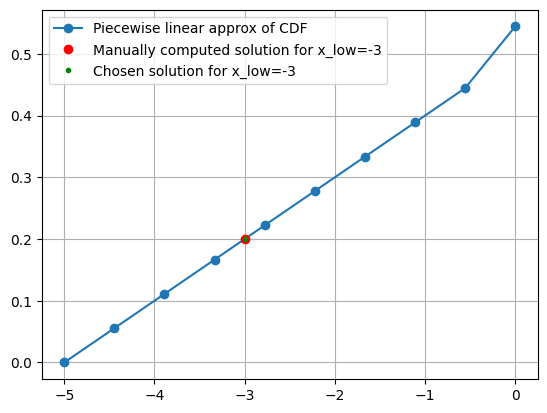

In [ ]:
plt.plot(x_range_low.tolist(), cdf_values_low, '-o', label='Piecewise linear approx of CDF')
plt.plot([-3], [0.2], 'ro', label='Manually computed solution for x_low=-3')
plt.plot([-3], [model.prob1.value], 'g.', label='Chosen solution for x_low=-3')
plt.grid()
plt.legend()

In [ ]:
model.prob2.value

0.39999999999999997

In [ ]:
int_low_values

[-1.25,
 -0.9876543209876546,
 -0.7561728395061728,
 -0.5555555555555556,
 -0.38580246913580246,
 -0.24691358024691365,
 -0.1388888888888889,
 -0.06172839506172836,
 -0.01543209876543209,
 0.0]

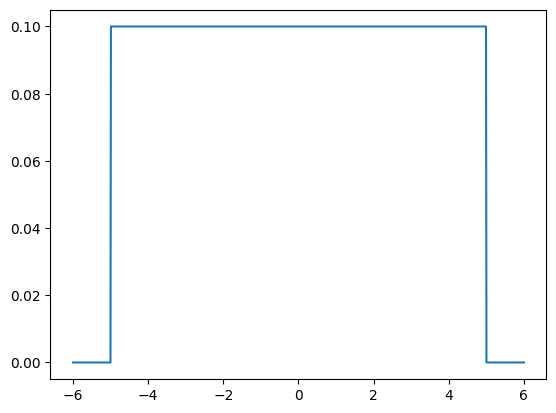

In [ ]:
pdf_vals = [pdf_func(z) for z in x]
plt.plot(x, pdf_vals)

# Minimal Pyomo Piecewise Error Example
This is a pyomo piecewise bug example using ipopt

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:       32
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

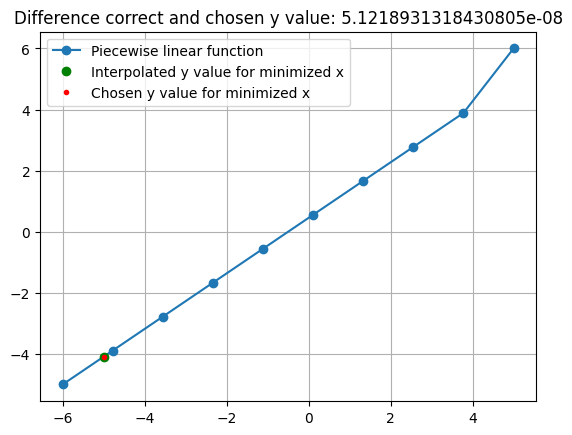

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:       32
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

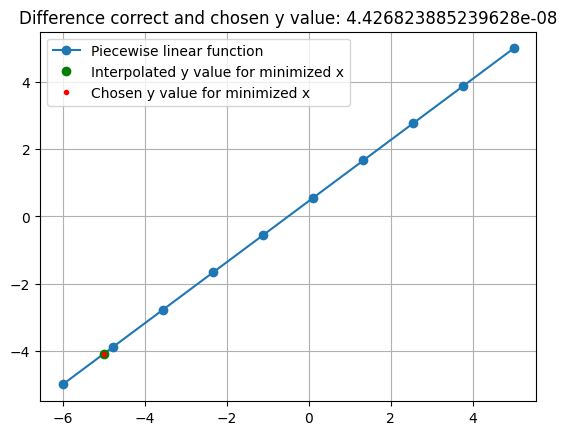

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:       32
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

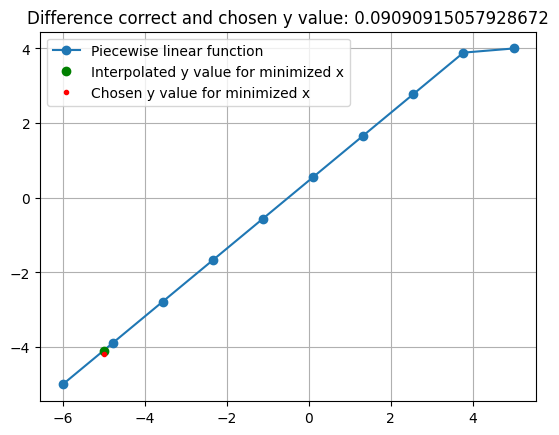

In [ ]:
import pyomo.environ as pyo
import numpy as np

x_bkpts = list(np.linspace(-6, 5, 10))
y_bkpts_fix = list(np.linspace(-5, 5, 10))

added_val = [1.0, 0.0, -1.0]
for val in added_val:
    y_bkpts = y_bkpts_fix.copy()
    y_bkpts[-1] = y_bkpts[-1] + val

    model = pyo.ConcreteModel()
    model.x = pyo.Var(domain=pyo.Reals, bounds=(-5, 5))
    model.y = pyo.Var(domain=pyo.Reals)
    model.z = pyo.Var(domain=pyo.Binary)

    model.pw = pyo.Piecewise(
        model.y,
        model.x,
        pw_pts=x_bkpts,
        f_rule=y_bkpts,
        pw_constr_type='EQ'
    )

    def objective_rule(model):
        return model.x + model.y
    model.obj = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

    # Solve the model
    solver = pyo.SolverFactory('ipopt')
    solver.solve(model, tee=True)

    y_linear = np.interp(model.x.value, x_bkpts, y_bkpts)
    plt.plot(x_bkpts, y_bkpts, 'o-', label='Piecewise linear function')
    plt.plot([model.x.value], [y_linear], 'og', label='Interpolated y value for minimized x')
    plt.plot([model.x.value], [model.y.value], '.r', label='Chosen y value for minimized x')
    plt.grid()
    plt.legend()
    plt.title('Difference correct and chosen y value: ' + str(y_linear - model.y.value))
    
    print('Difference between correct and chosen y value:', y_linear - model.y.value)
    plt.show()

In [ ]:
model.obj.display()

obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : -9.181818241488378


Difference between correct and chosen y value: 0.09090915057928672


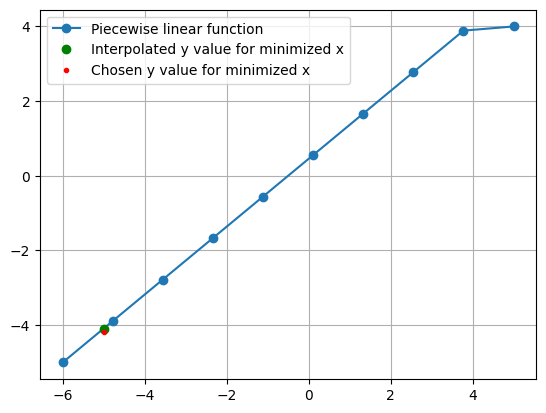

In [ ]:
y_linear = np.interp(model.x.value, x_bkpts, y_bkpts)
plt.plot(x_bkpts, y_bkpts, 'o-', label='Piecewise linear function')
plt.plot([model.x.value], [y_linear], 'og', label='Interpolated y value for minimized x')
plt.plot([model.x.value], [model.y.value], '.r', label='Chosen y value for minimized x')
plt.grid()
plt.legend()

print('Difference between correct and chosen y value:', y_linear - model.y.value)

In [ ]:
model.obj.display()

obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : -9.181818241488378


In [ ]:
model.prob1.display()

AttributeError: 'ConcreteModel' object has no attribute 'prob1'

In [ ]:
model.prob2.display()

prob2 : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :     0 : 0.4550002021760539 :     1 : False : False :  Reals


In [ ]:
model.x_low.display()

x_low : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  -6.0 : -5.495198574717293 :     0 : False : False :  Reals


In [ ]:
model.x_high.display()

x_high : Size=1, Index=None
    Key  : Lower : Value                  : Upper : Fixed : Stale : Domain
    None :     0 : 1.7587929023824055e-08 :   6.0 : False : False :  Reals


In [ ]:
class UncertaintySplitting:

    def __init__(self):
        #self.problem = problem
        #self.uncertainty = uncertainty
        self.model = self.initialize_model()
        pass


    # initialize the optimization problem
    def initialize_model(self):
        model = pyo.ConcreteModel()

        return model
    

    def test_the_op(self, prosumption_forecast: pd.DataFrame, prosumption_cdf: pd.DataFrame,
                    prosumption_pdf: pd.DataFrame, e0: float, t_inc: float,
                    e_min: float, e_max: float, pb_min: float, pb_max: float,
                    pl_discretize_limit: float, **kwargs):
        
        # Pyomo Sets
        self.model.time = pyo.Set(dimen=1, initialize=prosumption_forecast.index)
        self.model.time_e = pyo.Set(dimen=1, initialize=prosumption_forecast.index.append(pd.Index([prosumption_forecast.index[-1] + prosumption_forecast.index.freq])))
        self.model.time_e0 = pyo.Set(dimen=1, initialize=prosumption_forecast.index.to_list()[:1])


        # Pyomo Parameters
        self.model.pl = pyo.Param(self.model.time, initialize=prosumption_forecast['prosumption'].to_dict())
        self.model.e0 = pyo.Param(self.model.time_e0, initialize=e0) # initial energy storage level




        # Pyomo Decision Variables
        self.model.pg = pyo.Var(self.model.time, domain=pyo.Reals)

        self.model.pb = pyo.Var(self.model.time, domain=pyo.Reals)
        self.model.pb_dv = pyo.Var(self.model.time, domain=pyo.Reals)

        self.model.x_low = pyo.Var(self.model.time, domain=pyo.Reals, bounds=(-pl_discretize_limit, 0))
        self.model.x_high = pyo.Var(self.model.time, domain=pyo.Reals, bounds=(0, pl_discretize_limit))

        self.model.e = pyo.Var(self.model.time_e, domain=pyo.Reals)

        self.model.pb_tilde = pyo.Var(self.model.time, domain=pyo.Reals)

        self.model.prob1 = pyo.Var(self.model.time, domain=pyo.NonNegativeReals)
        self.model.prob2 = pyo.Var(self.model.time, domain=pyo.NonNegativeReals)



        # Pyomo Constraints
        # def constr_x_low(model, time):
        #     return model.x_low[time] <= 0
        # self.model.constr_x_low = pyo.Constraint(self.model.time, rule=constr_x_low)

        # def constr_x_high(model, time):
        #     return model.x_high[time] >= 0
        # self.model.constr_x_high = pyo.Constraint(self.model.time, rule=constr_x_high)



    
        




#         # Precompute the CDF values over a range of specified x values
#         x_low_range = np.linspace(-pl_discretize_limit, 0, 20)  # todo: make these bounds dynamic and dont use linspace. Vals near zero are more important
#         x_high_range = np.linspace(0, pl_discretize_limit, 20)  

#         cdf_vals_low = {time: [cdf_func(xl) for xl in x_low_range] for time, cdf_func in zip(self.model.time, cdf_functions)}
#         cdf_vals_high = {time: [cdf_func(xh) for xh in x_high_range] for time, cdf_func in zip(self.model.time, cdf_functions)}







# # Create a dictionary to hold interpolators
# cdf_values = {time: [cdf_func(x) for x in x_low_range] for time, cdf_func in zip(op.time, cdf_functions)}

# # Create the Piecewise components
# op.piecewise_constraints = pyo.ConstraintList()

# for t in op.time:
#     op.add_component(f"pw_{t}", pyo.Piecewise(
#         op.p1[t],                   # Variable to be constrained
#         op.x_low[t],                # x-coordinate for the piecewise function
#         pw_pts=x_low_range.tolist(),    # Breakpoints for the piecewise function
#         pw_constr_type='EQ',        # Specifies that the constraints are equalities (instead of inequalities)
#         f_rule=cdf_values[t]        # Values of the piecewise function at the breakpoints
#     ))








        def constr_e_evolution(model, time):
            if time == model.time_e.first():
                return model.e[time] == model.e0[time]
            else:
                prev_time = model.time_e.prev(time)
                return model.e[time] == model.e[prev_time] + t_inc * model.pb_dv[prev_time] + t_inc * model.pb_tilde[prev_time]  
        self.model.constr_e_evolution = pyo.Constraint(self.model.time_e, rule=constr_e_evolution) 






    

        self.model.delta_e_min = pyo.Var(self.model.time_e, domain=pyo.Reals)
        self.model.delta_e_max = pyo.Var(self.model.time_e, domain=pyo.Reals)

        def constr_delta_e_min(model, time):
            if time == model.time_e.first():
                return model.delta_e_min[time] == 0
            else:
                prev_time = model.time_e.prev(time)
                return model.delta_e_min[time] == model.delta_e_min[prev_time] + t_inc * model.x_low[prev_time] - t_inc * model.pb_tilde[prev_time]  # Careful with the signs of pb_tilde here
        self.model.constr_delta_e_min = pyo.Constraint(self.model.time_e, rule=constr_delta_e_min)

        def constr_delta_e_max(model, time):
            if time == model.time_e.first():
                return model.delta_e_max[time] == 0
            else:
                prev_time = model.time_e.prev(time)
                return model.delta_e_max[time] == model.delta_e_max[prev_time] + t_inc * model.x_high[prev_time] - t_inc * model.pb_tilde[prev_time]  # Careful with the signs of pb_tilde here
        self.model.constr_delta_e_max = pyo.Constraint(self.model.time_e, rule=constr_delta_e_max)

        def constr_e_limit_min(model, time):
            return model.e[time] + model.delta_e_min[time] >= e_min
        self.model.constr_e_limit_min = pyo.Constraint(self.model.time_e, rule=constr_e_limit_min)

        def constr_e_limit_max(model, time):
            return model.e[time] + model.delta_e_max[time] <= e_max
        self.model.constr_e_limit_max = pyo.Constraint(self.model.time_e, rule=constr_e_limit_max)

        

        def constr_pb_limit_min(model, time):
            return model.pb[time] + model.x_low[time] >= pb_min
        self.model.constr_pb_limit_min = pyo.Constraint(self.model.time, rule=constr_pb_limit_min)

        def constr_pb_limit_max(model, time):
            return model.pb[time] + model.x_high[time] <= pb_max
        self.model.constr_pb_limit_max = pyo.Constraint(self.model.time, rule=constr_pb_limit_max)


            
    
        

        # todo: Split pg into plus and minus part to be able to account for the different prices
        # todo: Split pb into plus and minus part to be able to include energy losses

        def dummy_objective(model):
            c1 = 0.5  # weight
            return sum(c1 * model.pg[time] for time in model.time)
        self.model.objective = pyo.Objective(rule=dummy_objective, sense=pyo.minimize)



In [ ]:
# Create artificial data
# prosumption_forecast, prosumption_pdf, prosumption_cdf, e0, t_inc, e_min, e_max, pb_min, pb_max
np.random.seed(0)

e0 = 6.0 # initial energy storage level in kWh
e_min = 0.0
e_max = 10.0
pb_min = -5.0
pb_max = 5.0
t_inc = 1.0  # time increment in hours

start_date = '1/1/2020'
prosumption_forecast = pd.DataFrame({'prosumption': np.random.normal(1, 1, 24)}, index=pd.date_range(start=start_date, periods=24, freq='h'))
prosumption_forecast_dummy = pd.DataFrame({'prosumption': np.array([2]*24)}, index=pd.date_range(start=start_date, periods=24, freq='h'))

prosumption_pdf = pd.DataFrame(index=pd.date_range(start=start_date, periods=24, freq='h'), columns=['pdf'])
prosumption_cdf = pd.DataFrame(index=pd.date_range(start=start_date, periods=24, freq='h'), columns=['cdf'])

different_variances = 2 * np.random.beta(1, 1, 24)
for variance_id in range(len(different_variances)):
    prosumption_pdf.iloc[variance_id] = lambda z: stats.norm.pdf(z, loc=0, scale=different_variances[variance_id])
    prosumption_cdf.iloc[variance_id] = lambda z: stats.norm.cdf(z, loc=0, scale=different_variances[variance_id])

prosumption_cdf.iloc[0].values[0](0)

0.5

In [ ]:
prosumption_forecast_dummy.index[0]

Timestamp('2020-01-01 00:00:00')

In [ ]:
op = UncertaintySplitting()

In [ ]:
op.test_the_op(prosumption_forecast=prosumption_forecast_dummy, prosumption_cdf=prosumption_cdf, prosumption_pdf=prosumption_pdf, e0=e0, t_inc=t_inc, e_min=e_min, e_max=e_max, pb_min=pb_min, pb_max=pb_max)

TypeError: UncertaintySplitting.test_the_op() missing 1 required positional argument: 'pl_discretize_limit'

# Testing

In [ ]:
import pandas as pd
import numpy as np
import pyomo.environ as pyo
from scipy import stats

np.random.seed(2)

# Sample start date for demonstration
start_date = '1/1/2020'
pl_discretize_limit = 3.0
t_inc = 1.0
e_min = 0.0
e_max = 10.0
pb_min = -5.0
pb_max = 5.0

# Generate a prosumption forecast as a DataFrame
# prosumption_forecast = pd.DataFrame({'prosumption': np.random.normal(1, 1, 24)}, 
#                                     index=pd.date_range(start=start_date, periods=24, freq='h'))
prosumption_forecast = pd.DataFrame({'prosumption': np.array([2]*24)}, index=pd.date_range(start=start_date, periods=24, freq='h'))


# Generate the CDF functions with different variances
#different_variances = 2 * np.random.beta(1, 1, 24) # !!!!!!!!! Uncertainty shift to the battery
#different_variances = np.array([1]*10 + [0.5, 0.5, 0.5, 0.5] + [1]*10) # No uncertainty shift to the battery
#different_variances = np.array([1]*8 + [0.5]*8 + [2]*8) # No uncertainty shift to the battery
different_variances = np.array([0.8]*24) # No uncertainty shift to the battery

cdf_functions = [lambda z, scale=scale: stats.norm.cdf(z, loc=0, scale=scale) for scale in different_variances]
pdf_functions = [lambda z, scale=scale: stats.norm.pdf(z, loc=0, scale=scale) for scale in different_variances]


# Create a ConcreteModel
op = pyo.ConcreteModel()

# Pyomo Sets
op.time = pyo.Set(initialize=prosumption_forecast.index)
op.time_e = pyo.Set(dimen=1, initialize=prosumption_forecast.index.append(pd.Index([prosumption_forecast.index[-1] + prosumption_forecast.index.freq])))
op.time_e0 = pyo.Set(dimen=1, initialize=prosumption_forecast.index.to_list()[:1])


# Pyomo Params
op.pl = pyo.Param(op.time, initialize=prosumption_forecast['prosumption'].to_dict())
op.e0 = pyo.Param(op.time_e0, initialize=6.0)

# Pyomo Decision Variables
op.e = pyo.Var(op.time_e, domain=pyo.Reals)
op.delta_e_min = pyo.Var(op.time_e, domain=pyo.NonPositiveReals)
op.delta_e_max = pyo.Var(op.time_e, domain=pyo.NonNegativeReals)

op.pg = pyo.Var(op.time, domain=pyo.Reals)

op.pb = pyo.Var(op.time, domain=pyo.Reals)
op.pb_dv = pyo.Var(op.time, domain=pyo.Reals)
op.delta_pb_min = pyo.Var(op.time, domain=pyo.NonPositiveReals)
op.delta_pb_max = pyo.Var(op.time, domain=pyo.NonNegativeReals)

op.x_low = pyo.Var(op.time, domain=pyo.Reals, bounds=(-pl_discretize_limit, 0)) # todo: make these bounds dynamic and dont use linspace. Vals near zero are more important
op.x_high = pyo.Var(op.time, domain=pyo.Reals, bounds=(0, pl_discretize_limit))

op.prob1 = pyo.Var(op.time, domain=pyo.NonNegativeReals, bounds=(0, 1))
op.prob2 = pyo.Var(op.time, domain=pyo.NonNegativeReals, bounds=(0, 1))

op.integral_low = pyo.Var(op.time, domain=pyo.Reals)
op.integral_high = pyo.Var(op.time, domain=pyo.Reals)

op.pb_tilde = pyo.Var(op.time, domain=pyo.Reals)


# Precompute the CDF values over a range of x_low
x_low_range = np.linspace(-pl_discretize_limit, 0, 50)  # Define the range and resolution as needed
x_high_range = np.linspace(0, pl_discretize_limit, 50)  # Define the range and resolution as needed

# Create a dictionary to hold interpolators
prob_lower_values = {time: [cdf_func(x) for x in x_low_range] for time, cdf_func in zip(op.time, cdf_functions)}  # p1(x) = F(x)
prob_higher_values = {time: [1 - cdf_func(x) for x in x_high_range] for time, cdf_func in zip(op.time, cdf_functions)}  # p2(x) = 1 - F(x)


# Create the Piecewise components
#op.piecewise_constraints = pyo.ConstraintList()

for t in op.time:
    op.add_component(f"pw_prob1_{t}", pyo.Piecewise(
        op.prob1[t],                   # Variable to be constrained
        op.x_low[t],                # x-coordinate for the piecewise function
        pw_pts=x_low_range.tolist(),    # Breakpoints for the piecewise function
        pw_constr_type='EQ',        # Specifies that the constraints are equalities (instead of inequalities)
        f_rule=prob_lower_values[t]        # Values of the piecewise function at the breakpoints
    ))

for t in op.time:
    op.add_component(f"pw_prob2_{t}", pyo.Piecewise(
        op.prob2[t],                   # Variable to be constrained
        op.x_high[t],                # x-coordinate for the piecewise function
        pw_pts=x_high_range.tolist(),    # Breakpoints for the piecewise function
        pw_constr_type='EQ',        # Specifies that the constraints are equalities (instead of inequalities)
        f_rule=prob_higher_values[t]        # Values of the piecewise function at the breakpoints
    ))


# Precompute the integral of the PDF for pb_tilde
def compute_integral(pdf_func, a, b): # todo: Add correct computation of the integral as expected value
    integrand = lambda z: z * pdf_func(z)
    expected_val, _ = integrate.quad(integrand, a, b)
    return expected_val


integral_values_low = {time: [compute_integral(pdf, x_low_range[i], 0) for i in range(len(x_low_range))] for time, pdf in zip(op.time, pdf_functions)}
integral_values_high = {time: [compute_integral(pdf, 0, x_high_range[j]) for j in range(len(x_high_range))] for time, pdf in zip(op.time, pdf_functions)}



#op.piecewise_integral_constraints_low = pyo.ConstraintList()
for t in op.time:
    op.add_component(f"pw_int_low_{t}", pyo.Piecewise(
        op.integral_low[t],
        op.x_low[t],
        pw_pts=x_low_range.tolist(),
        f_rule=integral_values_low[t],
        pw_constr_type='EQ'
    ))  

#op.piecewise_integral_constraints_high = pyo.ConstraintList()
for t in op.time:
    op.add_component(f"pw_int_high_{t}", pyo.Piecewise(
        op.integral_high[t],
        op.x_high[t],
        pw_pts=x_high_range.tolist(),
        f_rule=integral_values_high[t],
        pw_constr_type='EQ'
    ))


def constr_pb_tilde(model, time):
    return model.pb_tilde[time] == model.integral_low[time] + model.integral_high[time] + model.prob1[time] * model.x_low[time] + model.prob2[time] * model.x_high[time]
op.constr_pb_tilde = pyo.Constraint(op.time, rule=constr_pb_tilde)



def constr_e_evolution(model, time):
    if time == model.time_e.first():
        return model.e[time] == model.e0[time]
    else:
        prev_time = model.time_e.prev(time)
        return model.e[time] == model.e[prev_time] + t_inc * model.pb_dv[prev_time] + t_inc * model.pb_tilde[prev_time]
op.constr_e_evolution = pyo.Constraint(op.time_e, rule=constr_e_evolution)


def constr_delta_e_min(model, time):
    if time == model.time_e.first():
        return model.delta_e_min[time] == 0
    else:
        prev_time = model.time_e.prev(time)
        return model.delta_e_min[time] == model.delta_e_min[prev_time] + t_inc * model.x_low[prev_time] - t_inc * model.pb_tilde[prev_time]  # Careful with the signs of pb_tilde here
op.constr_delta_e_min = pyo.Constraint(op.time_e, rule=constr_delta_e_min)



def constr_delta_e_max(model, time):
    if time == model.time_e.first():
        return model.delta_e_max[time] == 0
    else:
        prev_time = model.time_e.prev(time)
        return model.delta_e_max[time] == model.delta_e_max[prev_time] + t_inc * model.x_high[prev_time] - t_inc * model.pb_tilde[prev_time]  # Careful with the signs of pb_tilde here
op.constr_delta_e_max = pyo.Constraint(op.time_e, rule=constr_delta_e_max)



def constr_e_limit_min(model, time):
    return model.e[time] + model.delta_e_min[time] >= e_min
op.constr_e_limit_min = pyo.Constraint(op.time_e, rule=constr_e_limit_min)

def constr_e_limit_max(model, time):
    return model.e[time] + model.delta_e_max[time] <= e_max
op.constr_e_limit_max = pyo.Constraint(op.time_e, rule=constr_e_limit_max)



def constr_delta_pb_min(model, time):
    return model.delta_pb_min[time] == model.x_low[time] - model.pb_tilde[time]
op.constr_delta_pb_min = pyo.Constraint(op.time, rule=constr_delta_pb_min)

def constr_delta_pb_max(model, time):
    return model.delta_pb_max[time] == model.x_high[time] - model.pb_tilde[time]
op.constr_delta_pb_max = pyo.Constraint(op.time, rule=constr_delta_pb_max)



def constr_pb_limit_min(model, time):  # todo: Check if pb_tilde should be used here as well!
    return model.pb[time] + model.delta_pb_min[time] >= pb_min
op.constr_pb_limit_min = pyo.Constraint(op.time, rule=constr_pb_limit_min)

def constr_pb_limit_max(model, time):
    return model.pb[time] + model.delta_pb_max[time] <= pb_max
op.constr_pb_limit_max = pyo.Constraint(op.time, rule=constr_pb_limit_max)

def constr_pb(model, time):
    return model.pb[time] == model.pb_dv[time] + model.pb_tilde[time]
op.constr_pb = pyo.Constraint(op.time, rule=constr_pb)




def constr_power_balance(model, time):
    return model.pg[time] == model.pl[time] - model.pb[time]
op.constr_power_balance = pyo.Constraint(op.time, rule=constr_power_balance)



# Define an example objective function
def objective_rule(model):
    return sum(model.pg[t] for t in model.time) # model.prob1[t] for t in model.time
op.obj = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# Solve the model
solver = pyo.SolverFactory('ipopt')
result = solver.solve(op, tee=True)

# # Display the results
# for t in op.time:
#     print(f"Time {t}: x_low = {op.x_low[t].value}, x_high = {op.x_high[t].value}, p1 = {op.p1[t].value}")


Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    15171
Number of nonzeros in inequality constraint Jacobian.:      196
Number of nonzeros in Lagrangian Hessian.............:       48

Total number of variables............................:     5163
                     variables with only lower bounds:     4849
                variables with lower and upper bounds:       96


In [ ]:
op.obj.display()

obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 44.00000079474472


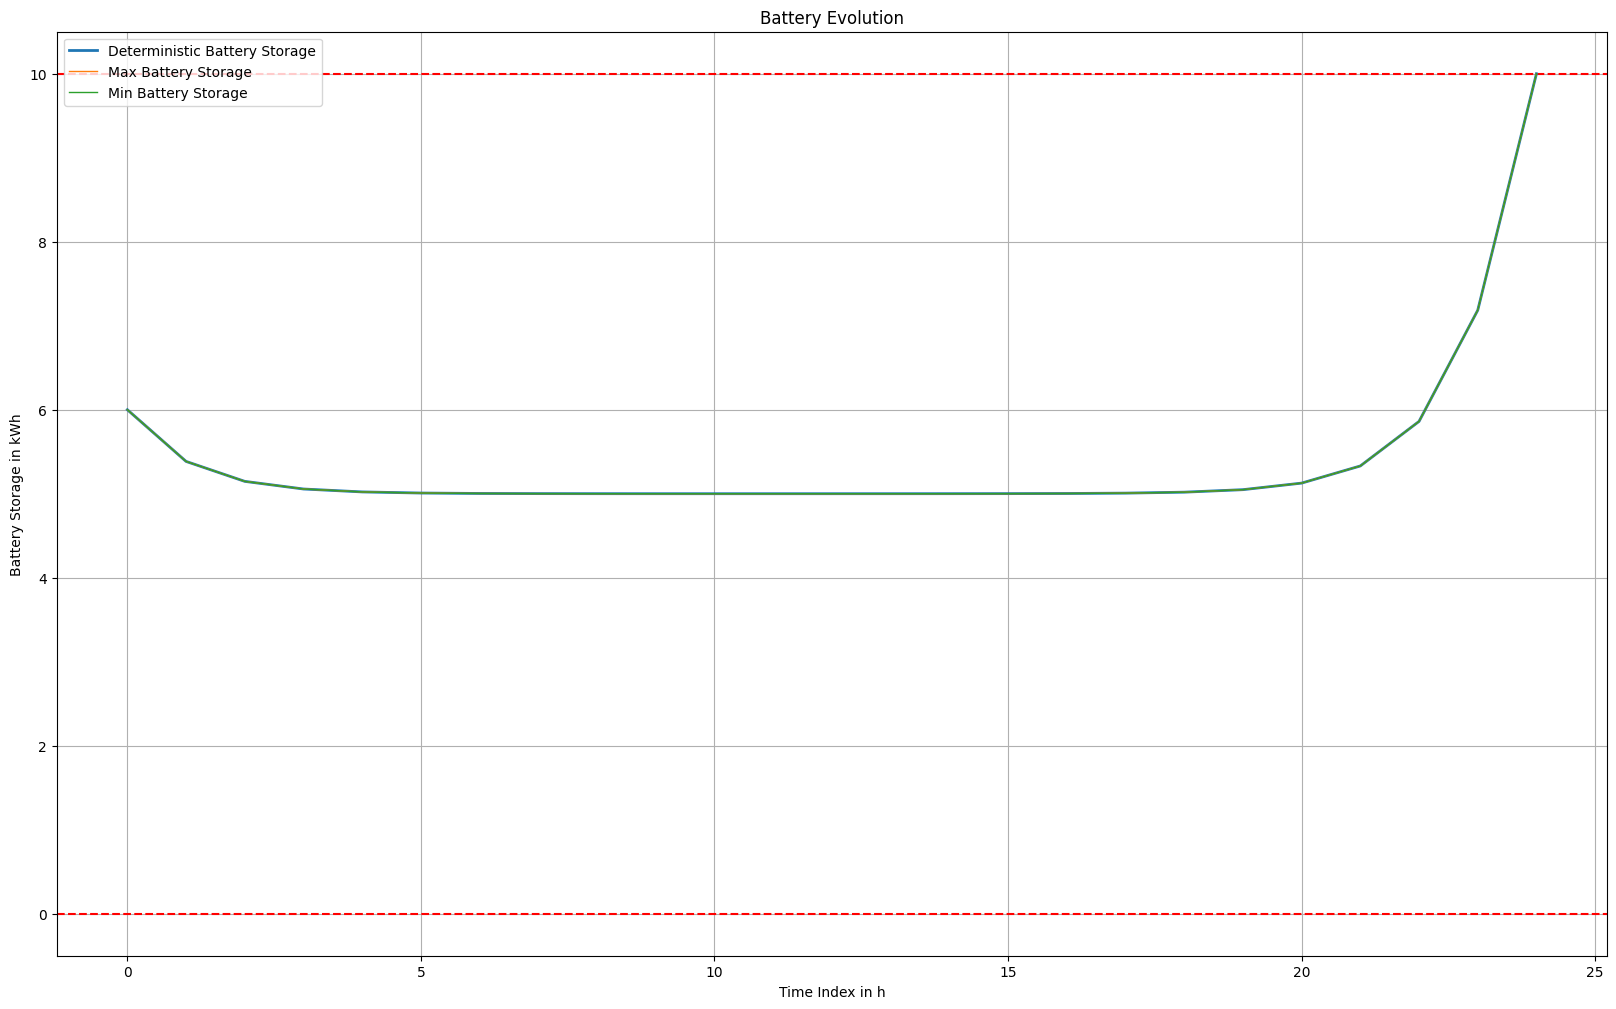

In [ ]:
# Get the values from op.e
e_values = [op.e[t].value for t in op.time_e]

delta_e_max_vals = [op.delta_e_max[t].value for t in op.time_e]
delta_e_min_vals = [op.delta_e_min[t].value for t in op.time_e]
e_max_vals = [e_det + e_prob for e_det, e_prob in zip(e_values, delta_e_max_vals)]
e_min_vals = [e_det + e_prob for e_det, e_prob in zip(e_values, delta_e_min_vals)]



# Get the index values
index_values = range(len(e_values))



# Plot the values
fig = plt.figure(figsize=(20, 12))
plt.axhline(y=e_max, color='red', linestyle='--')
plt.axhline(y=e_min, color='red', linestyle='--')
plt.plot(index_values, e_values, linewidth=2, label='Deterministic Battery Storage')
plt.plot(index_values, e_max_vals, linewidth=1, label='Max Battery Storage')
plt.plot(index_values, e_min_vals, linewidth=1, label='Min Battery Storage')
plt.xlabel('Time Index in h')
plt.ylabel('Battery Storage in kWh')
plt.title('Battery Evolution')
plt.grid()
plt.legend()
plt.show()

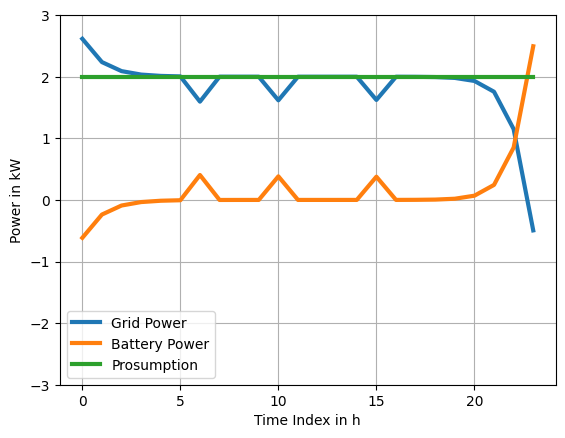

In [ ]:
pg_vals = [op.pg[t].value for t in op.time]
pb_vals = [op.pb[t].value for t in op.time]
pl_vals = [op.pl[t] for t in op.time]

index_values_p = range(len(pg_vals))

plt.plot(index_values_p, pg_vals, linewidth=3, label='Grid Power')
plt.plot(index_values_p, pb_vals, linewidth=3, label='Battery Power')
plt.plot(index_values_p, pl_vals, linewidth=3, label='Prosumption')
plt.xlabel('Time Index in h')
plt.ylabel('Power in kW')
plt.ylim(-3, 3)
plt.legend()
plt.grid()
plt.show()

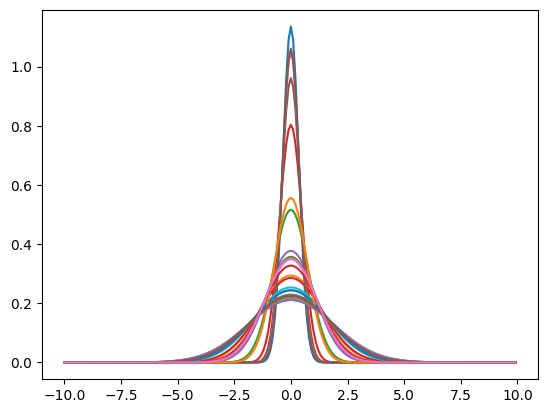

In [ ]:
# creta x values ranging from -10 to 10 with a resolution of 0.1
x_vals = np.arange(-10, 10, 0.1)
for pdf_func in pdf_functions:
    y_vals = [pdf_func(x) for x in x_vals]
    plt.plot(x_vals, y_vals)

# compute the integral of the pdf functions
integral_values = [integrate.quad(pdf_func, -np.inf, np.inf) for pdf_func in pdf_functions]

y_1 = [pdf_functions[0](x) for x in x_vals]
y_05 = [pdf_functions[8](x) for x in x_vals]
y_2 = [pdf_functions[16](x) for x in x_vals]

plt.plot(x_vals, y_1)
plt.plot(x_vals, y_05)
plt.plot(x_vals, y_2)

In [ ]:
integral_values

[(1.0000000000000002, 1.10929145241026e-09),
 (1.0000000000000002, 2.4812051811886953e-09),
 (1.0000000000000004, 2.8327348136248536e-09),
 (1.0000000000000009, 2.80163513433797e-09),
 (1.0, 3.5635458393542315e-09),
 (1.0, 5.749155523437788e-12),
 (1.0, 8.214724983918133e-12),
 (1.0000000000000002, 2.1913360276197037e-09),
 (1.0, 3.139303359491344e-09),
 (0.9999999999999999, 2.4607772209795633e-09),
 (1.0, 4.5095087597247556e-11),
 (1.0000000000000002, 5.424366663229141e-09),
 (1.0, 5.3410987814638285e-09),
 (1.0000000000000002, 5.379330776895619e-09),
 (1.0000000000000002, 4.1940566600592475e-09),
 (1.0000000000000002, 1.1140074302283543e-11),
 (1.0000000000000002, 5.111999365045971e-09),
 (1.0, 3.4581847631055175e-09),
 (1.0000000000000002, 1.3269635555172087e-09),
 (0.9999999999999999, 7.05994229017656e-10),
 (1.0, 2.603780907627551e-09),
 (0.9999999999999998, 8.015708242756757e-09),
 (1.0000000000000002, 3.1161622966792107e-09),
 (1.0, 5.543695944929067e-09)]

In [ ]:
op.display()

Model unknown

  Variables:
    e : Size=25, Index=time_e
        Key                 : Lower : Value             : Upper : Fixed : Stale : Domain
        2020-01-01 00:00:00 :  None :               6.0 :  None : False : False :  Reals
        2020-01-01 01:00:00 :  None : 5.384558758008196 :  None : False : False :  Reals
        2020-01-01 02:00:00 :  None : 5.147033951381386 :  None : False : False :  Reals
        2020-01-01 03:00:00 :  None : 5.056163009378238 :  None : False : False :  Reals
        2020-01-01 04:00:00 :  None : 5.021433634316849 :  None : False : False :  Reals
        2020-01-01 05:00:00 :  None : 5.008136526029989 :  None : False : False :  Reals
        2020-01-01 06:00:00 :  None : 5.002975641484528 :  None : False : False :  Reals
        2020-01-01 07:00:00 :  None : 5.407475529477549 :  None : False : False :  Reals
        2020-01-01 08:00:00 :  None : 5.406712114917565 :  None : False : False :  Reals
        2020-01-01 09:00:00 :  None : 5.406445103455

In [ ]:
op.prob1.display()

prob1 : Size=24, Index=time
    Key                 : Lower : Value                 : Upper : Fixed : Stale : Domain
    2020-01-01 00:00:00 :     0 :   0.49999999152563257 :     1 : False : False : NonNegativeReals
    2020-01-01 01:00:00 :     0 :   0.49999997369891597 :     1 : False : False : NonNegativeReals
    2020-01-01 02:00:00 :     0 :     0.499999973942165 :     1 : False : False : NonNegativeReals
    2020-01-01 03:00:00 :     0 :    0.4999999163599102 :     1 : False : False : NonNegativeReals
    2020-01-01 04:00:00 :     0 :     0.499999970985861 :     1 : False : False : NonNegativeReals
    2020-01-01 05:00:00 :     0 :    0.4999999003313152 :     1 : False : False : NonNegativeReals
    2020-01-01 06:00:00 :     0 :  0.007881369247675948 :     1 : False : False : NonNegativeReals
    2020-01-01 07:00:00 :     0 :   0.49999999104006243 :     1 : False : False : NonNegativeReals
    2020-01-01 08:00:00 :     0 :   0.49999999033735076 :     1 : False : False : NonNegati

: 

In [ ]:
# Check active constraints
def is_active_constraint(constr):
    try:
        return abs(pyo.value(constr.body) - pyo.value(constr.lower)) < 1e-6 or abs(pyo.value(constr.body) - pyo.value(constr.upper)) < 1e-6
    except:
        print(f"Error in constraint {constr.name}")
        return False

# Iterate through all constraints in the model
for constr_name in op.component_objects(pyo.Constraint, active=True):
    constr = getattr(op, constr_name.name)
    for index in constr:
        if is_active_constraint(constr[index]):
            print(f"Constraint {constr_name.name}[{index}] is active.")

Constraint constr_pb_tilde[2020-01-01 00:00:00] is active.
Constraint constr_pb_tilde[2020-01-01 01:00:00] is active.
Constraint constr_pb_tilde[2020-01-01 02:00:00] is active.
Constraint constr_pb_tilde[2020-01-01 03:00:00] is active.
Constraint constr_pb_tilde[2020-01-01 04:00:00] is active.
Constraint constr_pb_tilde[2020-01-01 05:00:00] is active.
Constraint constr_pb_tilde[2020-01-01 06:00:00] is active.
Constraint constr_pb_tilde[2020-01-01 07:00:00] is active.
Constraint constr_pb_tilde[2020-01-01 08:00:00] is active.
Constraint constr_pb_tilde[2020-01-01 09:00:00] is active.
Constraint constr_pb_tilde[2020-01-01 10:00:00] is active.
Constraint constr_pb_tilde[2020-01-01 11:00:00] is active.
Constraint constr_pb_tilde[2020-01-01 12:00:00] is active.
Constraint constr_pb_tilde[2020-01-01 13:00:00] is active.
Constraint constr_pb_tilde[2020-01-01 14:00:00] is active.
Constraint constr_pb_tilde[2020-01-01 15:00:00] is active.
Constraint constr_pb_tilde[2020-01-01 16:00:00] is activ

AttributeError: 'ConcreteModel' object has no attribute ''pw_prob1_2020-01-01 00:00:00'.SOS2_constraint'

In [ ]:
for var in op.component_objects(pyo.Var, active=True):
    varobject = getattr(op, str(var))
    for index in var:
        print("Variable", str(var), " ", index, pyo.value(varobject[index]))

Variable e   2020-01-01 00:00:00 6.0
Variable e   2020-01-01 01:00:00 5.445538599193369
Variable e   2020-01-01 02:00:00 5.200915345640205
Variable e   2020-01-01 03:00:00 5.093139549846629
Variable e   2020-01-01 04:00:00 5.048071094836139
Variable e   2020-01-01 05:00:00 5.035173629437642
Variable e   2020-01-01 06:00:00 5.045729781296945
Variable e   2020-01-01 07:00:00 5.380305266105925
Variable e   2020-01-01 08:00:00 5.400316000196876
Variable e   2020-01-01 09:00:00 5.415499061669774
Variable e   2020-01-01 10:00:00 5.438096633781695
Variable e   2020-01-01 11:00:00 5.759841508322204
Variable e   2020-01-01 12:00:00 5.7793327142161255
Variable e   2020-01-01 13:00:00 5.789238494113049
Variable e   2020-01-01 14:00:00 5.7993025110727014
Variable e   2020-01-01 15:00:00 5.819423313609038
Variable e   2020-01-01 16:00:00 6.140546527008591
Variable e   2020-01-01 17:00:00 6.159489361551569
Variable e   2020-01-01 18:00:00 6.170625447168881
Variable e   2020-01-01 19:00:00 6.18760565

ValueError: No value for uninitialized NumericValue object delta_pb_min[2020-01-02 00:00:00]

In [ ]:
op.e.display()

e : Size=25, Index=time_e
    Key                 : Lower : Value             : Upper : Fixed : Stale : Domain
    2020-01-01 00:00:00 :  None :               6.0 :  None : False : False :  Reals
    2020-01-01 01:00:00 :  None : 5.384558758008196 :  None : False : False :  Reals
    2020-01-01 02:00:00 :  None : 5.147033951381386 :  None : False : False :  Reals
    2020-01-01 03:00:00 :  None : 5.056163009378238 :  None : False : False :  Reals
    2020-01-01 04:00:00 :  None : 5.021433634316849 :  None : False : False :  Reals
    2020-01-01 05:00:00 :  None : 5.008136526029989 :  None : False : False :  Reals
    2020-01-01 06:00:00 :  None : 5.002975641484528 :  None : False : False :  Reals
    2020-01-01 07:00:00 :  None : 5.407475529477549 :  None : False : False :  Reals
    2020-01-01 08:00:00 :  None : 5.406712114917565 :  None : False : False :  Reals
    2020-01-01 09:00:00 :  None : 5.406445103455191 :  None : False : False :  Reals
    2020-01-01 10:00:00 :  None : 5.406

In [ ]:
op.x_high.display()

x_high : Size=24, Index=time
    Key                 : Lower : Value                  : Upper : Fixed : Stale : Domain
    2020-01-01 00:00:00 :     0 : 1.1783236524293244e-07 :   3.0 : False : False :  Reals
    2020-01-01 01:00:00 :     0 :  8.649954917497961e-08 :   3.0 : False : False :  Reals
    2020-01-01 02:00:00 :     0 :  7.178340433589455e-08 :   3.0 : False : False :  Reals
    2020-01-01 03:00:00 :     0 :   4.12548218828345e-08 :   3.0 : False : False :  Reals
    2020-01-01 04:00:00 :     0 :  6.055387028679769e-08 :   3.0 : False : False :  Reals
    2020-01-01 05:00:00 :     0 : 3.4854424310936655e-08 :   3.0 : False : False :  Reals
    2020-01-01 06:00:00 :     0 :                    0.0 :   3.0 : False : False :  Reals
    2020-01-01 07:00:00 :     0 :  5.670996904722314e-08 :   3.0 : False : False :  Reals
    2020-01-01 08:00:00 :     0 :  5.762497096474307e-08 :   3.0 : False : False :  Reals
    2020-01-01 09:00:00 :     0 :  5.917293286650192e-08 :   3.0 : Fals

In [ ]:
op.x_low.display()

x_low : Size=24, Index=time
    Key                 : Lower : Value                  : Upper : Fixed : Stale : Domain
    2020-01-01 00:00:00 :  -3.0 : -5.943646566925648e-10 :     0 : False : False :  Reals
    2020-01-01 01:00:00 :  -3.0 :                    0.0 :     0 : False : False :  Reals
    2020-01-01 02:00:00 :  -3.0 :                    0.0 :     0 : False : False :  Reals
    2020-01-01 03:00:00 :  -3.0 :                    0.0 :     0 : False : False :  Reals
    2020-01-01 04:00:00 :  -3.0 :                    0.0 :     0 : False : False :  Reals
    2020-01-01 05:00:00 :  -3.0 :                    0.0 :     0 : False : False :  Reals
    2020-01-01 06:00:00 :  -3.0 :    -0.9183674138769155 :     0 : False : False :  Reals
    2020-01-01 07:00:00 :  -3.0 :                    0.0 :     0 : False : False :  Reals
    2020-01-01 08:00:00 :  -3.0 :                    0.0 :     0 : False : False :  Reals
    2020-01-01 09:00:00 :  -3.0 :                    0.0 :     0 : False

In [ ]:
integral_values_low

{Timestamp('2020-01-01 00:00:00'): [-0.39894079368191804,
  -0.39893981693385394,
  -0.39893824076162443,
  -0.39893572474147115,
  -0.3989317518607941,
  -0.3989255464725087,
  -0.39891595920383077,
  -0.39890130800610024,
  -0.3988791621372724,
  -0.39884605345109364,
  -0.39879709719591,
  -0.3987255029914098,
  -0.39862195627630265,
  -0.39847385195854873,
  -0.39826436601630005,
  -0.39797135821537877,
  -0.39756611072573333,
  -0.3970119238855245,
  -0.39626261202342117,
  -0.39526096896491963,
  -0.39393730379301445,
  -0.39220818092620247,
  -0.38997553195675544,
  -0.38712633628976656,
  -0.3835330888656787,
  -0.3790552809337343,
  -0.3735421086014415,
  -0.36683658882152936,
  -0.3587811999605296,
  -0.34922507260727553,
  -0.33803263724494065,
  -0.3250934938242592,
  -0.31033311303806593,
  -0.2937238228825027,
  -0.2752953926705697,
  -0.25514441765256435,
  -0.23344164846347748,
  -0.21043641631361765,
  -0.18645738829143407,
  -0.16190905190155183,
  -0.1372635703273996

In [ ]:
cdf_values

{Timestamp('2020-01-01 00:00:00'): [0.00011526856213678617,
  0.00024230276452007524,
  0.0004916109838160018,
  0.000962896701067298,
  0.00182104792848502,
  0.003326182591855907,
  0.005869022229189699,
  0.010007063053157789,
  0.0164934498728416,
  0.02628707053219699,
  0.04053055184649487,
  0.060484164222932416,
  0.08740939818099153,
  0.12240633797830103,
  0.16622239929114585,
  0.21906319200292312,
  0.28044477324460526,
  0.3491262473395081,
  0.42315048660675514,
  0.5],
 Timestamp('2020-01-01 01:00:00'): [4.90750083344932e-11,
  4.4144657068106343e-10,
  3.5457215735651276e-09,
  2.5436743948814923e-08,
  1.630382866948192e-07,
  9.340126526477131e-07,
  4.784570558077382e-06,
  2.192737484491517e-05,
  8.996068856593657e-05,
  0.000330646016456951,
  0.0010896990394946382,
  0.0032237016328497533,
  0.008572096316847822,
  0.020521946686345452,
  0.044324102699371364,
  0.08658986181698136,
  0.15349858521032123,
  0.24792664152827093,
  0.36673459489148813,
  0.5],
 Ti

In [ ]:
different_variances

array([1.35760195, 0.7728246 , 1.39735931, 1.13265348, 0.37610433,
       1.14034337, 1.73784283, 1.87449235, 1.57276644, 1.63770476,
       0.71723603, 1.77291277, 1.21806648, 0.80337408, 1.93362361,
       1.91598344, 1.09009846, 0.77811604, 1.76455724, 0.67988414,
       1.70622865, 1.26200658, 0.8745154 , 1.5583716 ])

In [ ]:
import pandas as pd
import numpy as np
import pyomo.environ as pyo
from scipy import stats
from scipy.integrate import quad

# Sample start date for demonstration
start_date = '1/1/2020'

# Generate a prosumption forecast as a DataFrame
prosumption_forecast = pd.DataFrame({'prosumption': np.random.normal(1, 1, 24)}, 
                                    index=pd.date_range(start=start_date, periods=24, freq='h'))

# Generate the CDF functions with different variances
different_variances = 2 * np.random.beta(1, 1, 24)
pdf_functions = [lambda z, scale=scale: stats.norm.pdf(z, loc=0, scale=scale) for scale in different_variances]

# Create a ConcreteModel
op = pyo.ConcreteModel()

# Define the time set
op.time = pyo.Set(initialize=prosumption_forecast.index)

# Define decision variables indexed over time
op.x_low = pyo.Var(op.time, domain=pyo.Reals, bounds=(-4, 0))
op.x_high = pyo.Var(op.time, domain=pyo.Reals, bounds=(0, 4))
op.p1 = pyo.Var(op.time, domain=pyo.Reals)
op.pb_tilde = pyo.Var(op.time, domain=pyo.Reals)

# Precompute the CDF values over a range of x_low
x_range = np.linspace(-5, 5, 20)  # Define the range and resolution as needed

# Store the breakpoints and function values for each time period
cdf_values = {time: [stats.norm.cdf(x, loc=0, scale=different_variances[i]) for x in x_range]
              for i, time in enumerate(op.time)}

# Create the Piecewise components for CDF
op.piecewise_constraints = pyo.ConstraintList()
for t in op.time:
    op.add_component(f"pw_{t}", pyo.Piecewise(
        op.p1[t], op.x_low[t],
        pw_pts=x_range.tolist(),
        pw_constr_type='EQ',
        f_rule=cdf_values[t]
    ))

# Precompute the integral of the PDF for pb_tilde
def compute_integral(pdf_func, a, b):
    return quad(pdf_func, a, b)[0]

integral_values = {time: [compute_integral(pdf_func, x_range[i], x_range[j]) 
                          for i in range(len(x_range)) for j in range(i, len(x_range))]
                   for time, pdf_func in zip(op.time, pdf_functions)}

# Define the constraints for pb_tilde using precomputed integral values
def piecewise_integral_constraint_rule(model, time):
    def f_rule(m, xl, xh):
        idx_low = np.searchsorted(x_range, xl)
        idx_high = np.searchsorted(x_range, xh)
        return integral_values[time][idx_low * len(x_range) + idx_high]

    return pyo.Piecewise(
        model.pb_tilde[time], [model.x_low[time], model.x_high[time]],
        pw_pts=[(xl, xh) for xl in x_range for xh in x_range if xl <= xh],
        f_rule=f_rule,
        pw_constr_type='EQ'
    )

op.constr_pb_tilde = pyo.Constraint(op.time, rule=piecewise_integral_constraint_rule)

# Define an example objective function
def objective_rule(model):
    return sum(model.p1[t] + model.pb_tilde[t] for t in model.time)
op.obj = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# Solve the model
solver = pyo.SolverFactory('ipopt')
solver.solve(op, tee=True)

# Display the results
for t in op.time:
    print(f"Time {t}: x_low = {op.x_low[t].value}, x_high = {op.x_high[t].value}, p1 = {op.p1[t].value}, pb_tilde = {op.pb_tilde[t].value}")


**WARNING: Piecewise component ''pw_2020-01-01 02:00:00'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component ''pw_2020-01-01 04:00:00'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component ''pw_2020-01-01 07:00:00'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component ''pw_2020-01-01 15:00:00'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piece

TypeError: Piecewise component has invalid argument type for domain variable, [<pyomo.core.base.var.VarData object at 0x000001EAC5AED470>, <pyomo.core.base.var.VarData object at 0x000001EAC5AEE2E0>]

In [ ]:
import pandas as pd
import numpy as np
import pyomo.environ as pyo
from scipy import stats
from scipy.integrate import quad

# Sample start date for demonstration
start_date = '1/1/2020'

# Generate a prosumption forecast as a DataFrame
prosumption_forecast = pd.DataFrame({'prosumption': np.random.normal(1, 1, 24)}, 
                                    index=pd.date_range(start=start_date, periods=24, freq='h'))

# Generate the CDF functions with different variances
different_variances = 2 * np.random.beta(1, 1, 24)
pdf_functions = [lambda z, scale=scale: stats.norm.pdf(z, loc=0, scale=scale) for scale in different_variances]

# Create a ConcreteModel
op = pyo.ConcreteModel()

# Define the time set
op.time = pyo.Set(initialize=prosumption_forecast.index)

# Define decision variables indexed over time
op.x_low = pyo.Var(op.time, domain=pyo.Reals, bounds=(-4, 0))
op.x_high = pyo.Var(op.time, domain=pyo.Reals, bounds=(0, 4))
op.p1 = pyo.Var(op.time, domain=pyo.Reals)
op.pb_tilde = pyo.Var(op.time, domain=pyo.Reals)

# Precompute the CDF values over a range of x_low
x_range = np.linspace(-5, 5, 20)  # Define the range and resolution as needed

# Store the breakpoints and function values for each time period
cdf_values = {time: [stats.norm.cdf(x, loc=0, scale=different_variances[i]) for x in x_range]
              for i, time in enumerate(op.time)}

# Create the Piecewise components for CDF
op.piecewise_constraints = pyo.ConstraintList()
for t in op.time:
    op.add_component(f"pw_{t}", pyo.Piecewise(
        op.p1[t], op.x_low[t],
        pw_pts=x_range.tolist(),
        pw_constr_type='EQ',
        f_rule=cdf_values[t]
    ))

# Precompute the integral of the PDF for pb_tilde
def compute_integral(pdf_func, a, b):
    return quad(pdf_func, a, b)[0]

# integral_values = {time: [compute_integral(pdf_func, x_range[i], x_range[j]) 
#                           for i in range(len(x_range)) for j in range(i, len(x_range))]
#                    for time, pdf_func in zip(op.time, pdf_functions)}


integral_values = {}
for i, time in enumerate(op.time):
    integral_values[time] = np.zeros((len(x_range), len(x_range)))
    for j, x1 in enumerate(x_range):
        for k, x2 in enumerate(x_range[j:], start=j):
            integral_values[time][j, k] = compute_integral(pdf_functions[i], x1, x2)



def piecewise_integral_constraint_rule(model, time):
    xl = model.x_low[time]
    xh = model.x_high[time]
    idx_low = np.searchsorted(x_range, xl())
    idx_high = np.searchsorted(x_range, xh())
    integral = integral_values[time][idx_low, idx_high]
    return model.pb_tilde[time] == integral


op.constr_pb_tilde = pyo.Constraint(op.time, rule=piecewise_integral_constraint_rule)   



# # Define the constraints for pb_tilde using precomputed integral values
# def piecewise_integral_constraint_rule(model, time):
#     def f_rule(m, xl, xh):
#         idx_low = np.searchsorted(x_range, xl)
#         idx_high = np.searchsorted(x_range, xh)
#         return integral_values[time][idx_low * len(x_range) + idx_high]

#     return pyo.Piecewise(
#         model.pb_tilde[time], [model.x_low[time], model.x_high[time]],
#         pw_pts=[(xl, xh) for xl in x_range for xh in x_range if xl <= xh],
#         f_rule=f_rule,
#         pw_constr_type='EQ'
#     )

#op.constr_pb_tilde = pyo.Constraint(op.time, rule=piecewise_integral_constraint_rule)

# Define an example objective function
def objective_rule(model):
    return sum(model.p1[t] + model.pb_tilde[t] for t in model.time)
op.obj = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# Solve the model
solver = pyo.SolverFactory('ipopt')
solver.solve(op, tee=True)

# Display the results
for t in op.time:
    print(f"Time {t}: x_low = {op.x_low[t].value}, x_high = {op.x_high[t].value}, p1 = {op.p1[t].value}, pb_tilde = {op.pb_tilde[t].value}")


**WARNING: Piecewise component ''pw_2020-01-01 02:00:00'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component ''pw_2020-01-01 15:00:00'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component ''pw_2020-01-01 16:00:00'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component ''pw_2020-01-01 18:00:00'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piece

TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'

In [ ]:
import pandas as pd
import numpy as np
import pyomo.environ as pyo
from scipy import stats
from scipy.integrate import quad

# Sample start date for demonstration
start_date = '1/1/2020'

# Generate a prosumption forecast as a DataFrame
prosumption_forecast = pd.DataFrame({'prosumption': np.random.normal(1, 1, 24)}, 
                                    index=pd.date_range(start=start_date, periods=24, freq='h'))

# Generate the CDF and PDF functions with different variances
different_variances = 2 * np.random.beta(1, 1, 24)
pdf_functions = [lambda z, scale=scale: stats.norm.pdf(z, loc=0, scale=scale) for scale in different_variances]
cdf_functions = [lambda z, scale=scale: stats.norm.cdf(z, loc=0, scale=scale) for scale in different_variances]

# Create a ConcreteModel
op = pyo.ConcreteModel()

# Define the time set
op.time = pyo.Set(initialize=prosumption_forecast.index)

# Define decision variables indexed over time
op.x_low = pyo.Var(op.time, domain=pyo.Reals, bounds=(-4, 0))
op.x_high = pyo.Var(op.time, domain=pyo.Reals, bounds=(0, 4))
op.p1 = pyo.Var(op.time, domain=pyo.Reals)
op.pb_tilde = pyo.Var(op.time, domain=pyo.Reals)

# Precompute the CDF values over a range of x_low
x_range = np.linspace(-5, 5, 20)  # Define the range and resolution as needed

# Store the breakpoints and function values for each time period
cdf_values = {time: [stats.norm.cdf(x, loc=0, scale=different_variances[i]) for x in x_range]
              for i, time in enumerate(op.time)}

# Create the Piecewise components for CDF
op.piecewise_constraints = pyo.ConstraintList()
for t in op.time:
    op.add_component(f"pw_{t}", pyo.Piecewise(
        op.p1[t], op.x_low[t],
        pw_pts=x_range.tolist(),
        pw_constr_type='EQ',
        f_rule=cdf_values[t]
    ))

# Precompute the integral of the PDF for pb_tilde
def compute_integral(pdf_func, a, b):
    return quad(pdf_func, a, b)[0]

integral_values = {}
for i, time in enumerate(op.time):
    integral_values[time] = np.zeros((len(x_range), len(x_range)))
    for j, x1 in enumerate(x_range):
        for k, x2 in enumerate(x_range[j:], start=j):
            integral_values[time][j, k] = compute_integral(pdf_functions[i], x1, x2)

# Define the constraint for pb_tilde using precomputed integral values
def piecewise_integral_constraint_rule(model, time):
    xl = model.x_low[time]
    xh = model.x_high[time]
    idx_low = np.searchsorted(x_range, xl())
    idx_high = np.searchsorted(x_range, xh())
    integral = integral_values[time][idx_low, idx_high]
    return model.pb_tilde[time] == integral

op.constr_pb_tilde = pyo.Constraint(op.time, rule=piecewise_integral_constraint_rule)

# Define an example objective function
def objective_rule(model):
    return sum(model.p1[t] + model.pb_tilde[t] for t in model.time)
op.obj = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# Solve the model
solver = pyo.SolverFactory('glpk')
solver.solve(op, tee=True)

# Display the results
for t in op.time:
    print(f"Time {t}: x_low = {op.x_low[t].value}, x_high = {op.x_high[t].value}, p1 = {op.p1[t].value}, pb_tilde = {op.pb_tilde[t].value}")


**WARNING: Piecewise component ''pw_2020-01-01 03:00:00'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component ''pw_2020-01-01 04:00:00'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component ''pw_2020-01-01 06:00:00'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component ''pw_2020-01-01 07:00:00'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piece

TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'

In [ ]:
import pandas as pd
import numpy as np
import pyomo.environ as pyo
from scipy import stats
from scipy.integrate import quad

# Sample start date for demonstration
start_date = '1/1/2020'

# Generate a prosumption forecast as a DataFrame
prosumption_forecast = pd.DataFrame({'prosumption': np.random.normal(1, 1, 24)}, 
                                    index=pd.date_range(start=start_date, periods=24, freq='h'))

# Generate the CDF functions with different variances
different_variances = 2 * np.random.beta(1, 1, 24)
pdf_functions = [lambda z, scale=scale: stats.norm.pdf(z, loc=0, scale=scale) for scale in different_variances]

# Create a ConcreteModel
op = pyo.ConcreteModel()

# Define the time set
op.time = pyo.Set(initialize=prosumption_forecast.index)

# Define decision variables indexed over time
op.x_low = pyo.Var(op.time, domain=pyo.Reals, bounds=(-4, 0))
op.x_high = pyo.Var(op.time, domain=pyo.Reals, bounds=(0, 4))
op.p1 = pyo.Var(op.time, domain=pyo.Reals)
op.pb_tilde = pyo.Var(op.time, domain=pyo.Reals)

# Precompute the CDF values over a range of x_low
x_range = np.linspace(-5, 5, 20)  # Define the range and resolution as needed

# Store the breakpoints and function values for each time period
cdf_values = {time: [stats.norm.cdf(x, loc=0, scale=different_variances[i]) for x in x_range]
              for i, time in enumerate(op.time)}

# Create the Piecewise components for CDF
op.piecewise_constraints = pyo.ConstraintList()
for t in op.time:
    op.add_component(f"pw_{t}", pyo.Piecewise(
        op.p1[t], op.x_low[t],
        pw_pts=x_range.tolist(),
        pw_constr_type='EQ',
        f_rule=cdf_values[t]
    ))

# Precompute the integral of the PDF for pb_tilde
def compute_integral(pdf_func, a, b):
    return quad(pdf_func, a, b)[0]

# integral_values = {time: [compute_integral(pdf_func, x_range[i], x_range[j]) 
#                           for i in range(len(x_range)) for j in range(i, len(x_range))]
#                    for time, pdf_func in zip(op.time, pdf_functions)}


integral_values = {}
for i, time in enumerate(op.time):
    integral_values[time] = np.zeros((len(x_range), len(x_range)))
    for j, x1 in enumerate(x_range):
        for k, x2 in enumerate(x_range[j:], start=j):
            integral_values[time][j, k] = compute_integral(pdf_functions[i], x1, x2)



# def piecewise_integral_constraint_rule(model, time):
#     xl = model.x_low[time]
#     xh = model.x_high[time]
#     idx_low = np.searchsorted(x_range, xl())
#     idx_high = np.searchsorted(x_range, xh())
#     integral = integral_values[time][idx_low, idx_high]
#     return model.pb_tilde[time] == integral


# op.constr_pb_tilde = pyo.Constraint(op.time, rule=piecewise_integral_constraint_rule)   



# # Define the constraints for pb_tilde using precomputed integral values
# def piecewise_integral_constraint_rule(model, time):
#     def f_rule(m, xl, xh):
#         idx_low = np.searchsorted(x_range, xl)
#         idx_high = np.searchsorted(x_range, xh)
#         return integral_values[time][idx_low * len(x_range) + idx_high]

#     return pyo.Piecewise(
#         model.pb_tilde[time], [model.x_low[time], model.x_high[time]],
#         pw_pts=[(xl, xh) for xl in x_range for xh in x_range if xl <= xh],
#         f_rule=f_rule,
#         pw_constr_type='EQ'
#     )

#op.constr_pb_tilde = pyo.Constraint(op.time, rule=piecewise_integral_constraint_rule)

# Define an example objective function
def objective_rule(model):
    return sum(model.p1[t] + model.pb_tilde[t] for t in model.time)
op.obj = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# Solve the model
solver = pyo.SolverFactory('ipopt')
solver.solve(op, tee=True)

# Display the results
for t in op.time:
    print(f"Time {t}: x_low = {op.x_low[t].value}, x_high = {op.x_high[t].value}, p1 = {op.p1[t].value}, pb_tilde = {op.pb_tilde[t].value}")


**WARNING: Piecewise component ''pw_2020-01-01 00:00:00'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component ''pw_2020-01-01 01:00:00'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component ''pw_2020-01-01 02:00:00'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component ''pw_2020-01-01 09:00:00'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piece

In [ ]:
integral_values

{Timestamp('2020-01-01 00:00:00'): array([[0.00000000e+00, 1.71953528e-12, 4.13677485e-10, 5.16061476e-08,
         3.36008967e-06, 1.14912805e-04, 2.08412027e-03, 2.03521742e-02,
         1.09738984e-01, 3.41157627e-01, 6.58842373e-01, 8.90261016e-01,
         9.79647826e-01, 9.97915880e-01, 9.99885087e-01, 9.99996640e-01,
         9.99999948e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 4.11957950e-10, 5.16044280e-08,
         3.36008795e-06, 1.14912803e-04, 2.08412027e-03, 2.03521742e-02,
         1.09738984e-01, 3.41157627e-01, 6.58842373e-01, 8.90261016e-01,
         9.79647826e-01, 9.97915880e-01, 9.99885087e-01, 9.99996640e-01,
         9.99999948e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.11924701e-08,
         3.35967599e-06, 1.14912391e-04, 2.08411986e-03, 2.03521738e-02,
         1.09738984e-01, 3.41157627e-01, 6.58842373e-01, 8.90261016e-01,
         9.7964

In [ ]:
# Testing if pyomo works with dv as function arguments
import pyomo.environ as pyo
from scipy import stats

# Create a ConcreteModel
model = pyo.ConcreteModel()

# Define decision variables
model.x = pyo.Var(domain=pyo.Reals, bounds=(0, 1))
model.y = pyo.Var(domain=pyo.Reals, bounds=(0, 1))

# Define the non-linear function (CDF of a normal distribution in this case)
def cdf_func(x):
    return stats.norm.cdf(x)

# Add the non-linear constraint y = f(x)
def non_linear_constraint(model):
    return model.y == cdf_func(model.x)

model.nl_con = pyo.Constraint(rule=non_linear_constraint)

# Define an example objective function
def objective_rule(model):
    return model.y

model.obj = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# Solve the model
solver = pyo.SolverFactory('ipopt')
solver.solve(model, tee=True)

# Display the results
print(f"x = {model.x.value}, y = {model.y.value}")


ERROR: Rule failed when generating expression for Constraint nl_con with index
None: PyomoException: Cannot convert non-constant Pyomo expression (-inf  <
x) to bool. This error is usually caused by using a Var, unit, or mutable
Param in a Boolean context such as an "if" statement, or when checking
container membership or equality. For example,
        >>> m.x = Var()
        >>> if m.x >= 1:
        ...     pass
    and
        >>> m.y = Var()
        >>> if m.y in [m.x, m.y]:
        ...     pass
    would both cause this exception.
ERROR: Constructing component 'nl_con' from data=None failed:
        PyomoException: Cannot convert non-constant Pyomo expression (-inf  <
        x) to bool.
    This error is usually caused by using a Var, unit, or mutable Param in a
    Boolean context such as an "if" statement, or when checking container
    membership or equality. For example,
        >>> m.x = Var()
        >>> if m.x >= 1:
        ...     pass
    and
        >>> m.y = Var()
     

PyomoException: Cannot convert non-constant Pyomo expression (-inf  <  x) to bool.
This error is usually caused by using a Var, unit, or mutable Param in a
Boolean context such as an "if" statement, or when checking container
membership or equality. For example,
    >>> m.x = Var()
    >>> if m.x >= 1:
    ...     pass
and
    >>> m.y = Var()
    >>> if m.y in [m.x, m.y]:
    ...     pass
would both cause this exception.

In [ ]:
np.sqrt(2)

1.4142135623730951

In [ ]:
import pyomo.environ as pyo
import numpy as np

# Create a ConcreteModel
model = pyo.ConcreteModel()

# Define decision variables
model.x = pyo.Var(domain=pyo.Reals, bounds=(0, 1))
model.y = pyo.Var(domain=pyo.Reals, bounds=(0, 1))

# Define the non-linear function using a Pyomo Expression
def cdf_func(x):
    # Normal CDF approximation using error function
    #return 0.5 * (1 + np.sqrt(0.1 + x))  # Doesnt work with np.sqrt
    return 0.5 * (1 + pyo.sqrt(0.1 + x))  # Works with pyo.sqrt

# Add the non-linear constraint y = f(x)
def non_linear_constraint(model):
    return model.y == cdf_func(model.x)

model.nl_con = pyo.Constraint(rule=non_linear_constraint)

# Define an example objective function
def objective_rule(model):
    return model.y

model.obj = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# Solve the model
solver = pyo.SolverFactory('ipopt')
solver.solve(model, tee=True)

# Display the results
print(f"x = {model.x.value}, y = {model.y.value}")


Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2


In [ ]:
import pyomo.environ as pyo
import numpy as np

simple_model_1 = pyo.ConcreteModel()
simple_model_1.x = pyo.Var(domain=pyo.PositiveReals)
def simple_rule_1(m):
    return pyo.sqrt(m.x)  # works
    #return np.sqrt(m.x)  # doesnt work
simple_model_1.obj = pyo.Objective(rule=simple_rule_1)